The main notebooks that helped me in performing the Exploratory Data Analysis for this project were as given below.

In [ ]:
'''
Reference: https://www.kaggle.com/calabist/resolving-mystery-of-reference-date/notebook
           https://www.kaggle.com/brendanhasz/elo-data-cleaning-and-eda
'''

# 1. Download dataset

In [2]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,mr-IN;q=0.8,mr;q=0.7" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/10445/200747/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1640348106&Signature=arsCj51kcdYD8C%2BHpwYKtWYLJBsX6T6Ltse%2B4WG4TTgxL3SVigJZQ2h9odR2Y%2FmBr40vmt0DWp3I1m7AArB17yiVp6nlXJP8H9ZnE9wuLslIyur2nmZhkJQdZdYXIaahTRryDcdpwuVOHEWQ4p8kMr%2BSj8uME8KU%2BsGCk5p%2FVaY7uCYuMF5vajD5DHGcOOZAh4vK4yutC%2BBS%2F9zOfdMZQsYv817gSAMiCvJNrrBNuSva65xSc6AD9ipCSaFdNmQzjXj4oQvkndcJKE1MIRPPVXf0t%2FGtNqOVBSYKoW04ELdwqPjx46zOlLyTOBb5bu45c9FzKGARXbiCCyNNBSX9Og%3D%3D&response-content-disposition=attachment%3B+filename%3Delo-merchant-category-recommendation.zip" -c -O 'elo-merchant-category-recommendation.zip'

--2021-12-21 12:15:30--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/10445/200747/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1640348106&Signature=arsCj51kcdYD8C%2BHpwYKtWYLJBsX6T6Ltse%2B4WG4TTgxL3SVigJZQ2h9odR2Y%2FmBr40vmt0DWp3I1m7AArB17yiVp6nlXJP8H9ZnE9wuLslIyur2nmZhkJQdZdYXIaahTRryDcdpwuVOHEWQ4p8kMr%2BSj8uME8KU%2BsGCk5p%2FVaY7uCYuMF5vajD5DHGcOOZAh4vK4yutC%2BBS%2F9zOfdMZQsYv817gSAMiCvJNrrBNuSva65xSc6AD9ipCSaFdNmQzjXj4oQvkndcJKE1MIRPPVXf0t%2FGtNqOVBSYKoW04ELdwqPjx46zOlLyTOBb5bu45c9FzKGARXbiCCyNNBSX9Og%3D%3D&response-content-disposition=attachment%3B+filename%3Delo-merchant-category-recommendation.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.128, 172.217.193.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 644665605 (615M) [application/zip]
Saving to: ‘elo-merchant-

In [3]:
!unzip "elo-merchant-category-recommendation.zip" -d "Modeling"

Archive:  /content/elo-merchant-category-recommendation.zip
  inflating: /content/Data Dictionary.xlsx  
  inflating: /content/Data_Dictionary.xlsx  
  inflating: /content/historical_transactions.csv  
  inflating: /content/merchants.csv  
  inflating: /content/new_merchant_transactions.csv  
  inflating: /content/sample_submission.csv  
  inflating: /content/test.csv       
  inflating: /content/train.csv      


# 2. Preperations: Libraries and Helper Functions


In [1]:
!pip install "dask[dataframe]"

In [1]:
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import gc
import datetime

In [2]:
#https://www.kaggle.com/fabiendaniel/elo-world
#Load data into pandas and save memory with this function.
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
# Reference : https://www.kaggle.com/lonewolf95/eda-101-univariate-analysis-for-beginners

def categorical_distributions(data, var_group):

  '''
  Univariate_Analysis_categorical
  takes a group of variables (category) and plot/print all the value_counts and barplot.
  data: data frame
  var_group - list of categorical features
  '''
  # setting figure_size
  size = len(var_group)
  plt.figure(figsize = (7*size,5), dpi = 100)

  # for every variable
  for j,i in enumerate(var_group):
      count = data[i].value_counts()
      no_uniq = data[i].nunique()
      total=len(data[i])


  #Plotting the variable with every information
      plt.subplot(1,size,j+1)
      ax = sns.barplot(count, count.index , order = count.index)  
      plt.xlabel('fraction/percent', fontsize = 20)
      plt.ylabel('{}'.format(i), fontsize = 20)

      
      for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), fontsize=15)

In [6]:
# Reference : https://www.kaggle.com/lonewolf95/eda-101-univariate-analysis-for-beginners

def numerical_distribution(data, var_group):
  '''
  Univariate_Analysis_numeric
  takes a group of variables (INTEGER and FLOAT) and plot/print all the descriptives and properties along with KDE.

  Runs a loop: calculate all the descriptives of i(th) variable and plot/print it
  
  data: data frame
  var_group - list of categorical features
  '''

  size = len(var_group)
  plt.figure(figsize = (7*size,3), dpi = 100)
  
  #looping for each variable
  for j,i in enumerate(var_group):
    
    # calculating descriptives of variable
    mini = data[i].min()
    maxi = data[i].max()
    ran = data[i].max()-data[i].min()
    mean = data[i].mean()
    median = data[i].median()
    st_dev = data[i].std()
    skew = data[i].skew()

    # calculating points of standard deviation
    points = mean-st_dev, mean+st_dev

    #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.kdeplot(data[i], shade=True)
    sns.lineplot(points, [0,0], color = 'black', label = "std_dev")
    sns.scatterplot([mini,maxi], [0,0], color = 'orange', label = "min/max")
    sns.scatterplot([mean], [0], color = 'red', label = "mean")
    sns.scatterplot([median], [0], color = 'blue', label = "median")
    plt.xlabel('{}'.format(i), fontsize = 20)
    plt.ylabel('density')
    plt.title('std_dev = {}; \nskew = {}; range = {}\nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                   round(skew,2),
                                                                                                   (round(mini,2),round(maxi,2),round(ran,2)),
                                                                                                   round(mean,2),
                                                                                                   round(median,2)))

In [7]:
#Category_1_Y against other features

def func1(df, v):
  for j,i in enumerate(v):
       df.loc[(df["category_1"]=="Y") , ["category_1",i]].plot(title='category_1 v/s {0}'.format(i), kind='line')


def func2(df,v2):
  for j,i in enumerate(v2):
       df.loc[(df["category_1"]=="Y") , ["category_1",i]].plot(title='category_1 v/s {0}'.format(i), kind='kde')

In [8]:
#Category_1_N against other features

def func3(df, v):
  for j,i in enumerate(v):
       df.loc[(df["category_1"]=="N") , ["category_1",i]].plot(title='category_1 v/s {0}'.format(i), kind='line')
      # plt.block(True)

def func4(df,v2):
  for j,i in enumerate(v2):
       df.loc[(df["category_1"]=="N") , ["category_1",i]].plot(title='category_1 v/s {0}'.format(i), kind='kde')

In [9]:
#Function which give feature verses target variable plot

def historical_vs_target(data, var_group):
    size = len(var_group)
    plt.figure(figsize = (7*size,3), dpi = 100)
    for j,i in enumerate(var_group):
        plt.subplot(1,size,j+1)
        sns.scatterplot(x='target', y=i, data=data)

In [10]:
#Categorical_3 verses installment feature

def func8(df, v):
  for j,i in enumerate(v):
       df.loc[(df["category_3"]=="A") , ["category_3",i]].plot(title='category_3_A v/s {0}'.format(i), kind='line')
      # plt.block(True)

def func9(df,v2):
  for j,i in enumerate(v2):
       df.loc[(df["category_3"]=="B") , ["category_3",i]].plot(title='category_3_B v/s {0}'.format(i), kind='line')

def func10(df,v2):
  for j,i in enumerate(v2):
       df.loc[(df["category_3"]=="C") , ["category_3",i]].plot(title='category_3_C v/s {0}'.format(i), kind='line')

In [11]:
#Categorical_3 verses installment remaining features

def func5(df, v):
  for j,i in enumerate(v):
       df.loc[(df["category_3"]=="A") , ["category_3",i]].plot(title='category_3 v/s {0}'.format(i), kind='kde')
      # plt.block(True)

def func6(df,v2):
  for j,i in enumerate(v2):
       df.loc[(df["category_3"]=="B") , ["category_3",i]].plot(title='category_3_B v/s {0}'.format(i), kind='kde')

def func7(df,v2):
  for j,i in enumerate(v2):
       df.loc[(df["category_3"]=="C") , ["category_3",i]].plot(title='category_3_C v/s {0}'.format(i), kind='kde')

# 3. Data Overview 

In [8]:
%%time
#Reading datasets

train = reduce_mem_usage(pd.read_csv("train.csv"))

test = reduce_mem_usage(pd.read_csv("test.csv"))

hist_tran = reduce_mem_usage(pd.read_csv("historical_transactions.csv"))

new_merch_tran = reduce_mem_usage(pd.read_csv("new_merchant_transactions.csv"))

merch = reduce_mem_usage(pd.read_csv("merchants.csv"))

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)
Mem. usage decreased to 30.32 Mb (46.0% reduction)
CPU times: user 47 s, sys: 4.39 s, total: 51.3 s
Wall time: 51.4 s


In [ ]:
%%time 
train.head()

CPU times: user 240 ms, sys: 45.1 ms, total: 285 ms
Wall time: 292 ms


,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [5]:
train.shape

(201917, 6)

In [ ]:
a = train.shape
a[0].compute(), a[1]

(201917, 6)

In [ ]:
%%time 
test.head()

CPU times: user 122 ms, sys: 20.2 ms, total: 142 ms
Wall time: 146 ms


,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


In [6]:
test.shape

(123623, 5)

In [ ]:
a = test.shape
a[0].compute(), a[1]

(123623, 5)

In [ ]:
%%time 
hist_tran.head()

CPU times: user 1.33 s, sys: 301 ms, total: 1.63 s
Wall time: 1.63 s


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [7]:
hist_tran.shape

(29112361, 14)

In [ ]:
a = hist_tran.shape
a[0].compute(), a[1]

(29112361, 14)

In [ ]:
%%time 
new_merch_tran.head()

CPU times: user 1.47 s, sys: 157 ms, total: 1.63 s
Wall time: 1.63 s


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [8]:
new_merch_tran.shape

(1963031, 14)

In [ ]:
a = new_merch_tran.shape
a[0].compute(), a[1]

(1963031, 14)

In [ ]:
%%time 
merch.head()

CPU times: user 1.08 s, sys: 68 ms, total: 1.15 s
Wall time: 1.16 s


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [9]:
merch.shape

(334696, 22)

In [ ]:
a = merch.shape
a[0].compute(), a[1]

(334696, 22)

# 3.1 Handling data mismatch between transaction data and merchants data.

There are three types of dataset present with us, excluding test data. They are train data, transactions data (both historical and new merchants transactions), and merchants data. Lets first combine the transactions data files together.

In [15]:
import gc
del transactions_data
gc.collect()

126

In [17]:
hist_tran = reduce_mem_usage(pd.read_csv("historical_transactions.csv"))

new_merch_tran = reduce_mem_usage(pd.read_csv("new_merchant_transactions.csv"))

Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)


In [20]:
%%time
transactions_data = reduce_mem_usage(pd.concat([hist_tran, new_merch_tran]))

Mem. usage decreased to 2104.14 Mb (0.0% reduction)
CPU times: user 4.83 s, sys: 336 ms, total: 5.16 s
Wall time: 5.16 s


In [ ]:
transactions_data.to_hdf('transactions_data.h5', key='df')

['transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',
 'transactions_data.h5',


In [21]:
transactions_data.shape

(31075392, 14)

In [ ]:
a = transactions_data.shape
a[0].compute(), a[1]

(31075392, 14)

In [13]:
hist_tran.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id'],
      dtype='object')

In [14]:
new_merch_tran.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id'],
      dtype='object')

In [22]:
transactions_data.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id'],
      dtype='object')

Now, going further, looking at transaction data and merchants data, there are few fields that appear in both the transaction data (historical transactions.csv and new merchant transactions.csv) and the merchant data (merchants.csv):



*   city_id
*   state_id

*   category_1
*   category_2

*   subsector_id
*   merchant_category_id

*   merchant_id

It is unclear weather the features present in both the files represent same information. We obviously want merchant id in both tables so that we can connect them, but it's unclear if the other columns in the transactions table indicate information about the merchant or about the transaction. Merchant category id and subsector id, at the very least, appear to provide information about the merchant, and so should be consistent across transactions involving the same merchant id, as well as matching the information in merchants.csv. If city id and state id are used to represent the merchant's corporate postal address, they should remain constant. If they reflect the city and state where the transaction took place, on the other hand, there could be several different values for the same merchant id. Because category 1 and category 2 appear in both databases, it's likely that they also represent merchant data.

Let us check to see whether this is correct. Let's start by loading only the columns that we're interested in:

In [24]:
#Lets just fetch the columns of interest.
merch = reduce_mem_usage(pd.read_csv("merchants.csv"))

col_list = ['city_id', 'state_id', 'category_1', 'category_2', 'subsector_id', 'merchant_category_id', 'merchant_id']

hist_check = transactions_data[['city_id', 'state_id', 'category_1', 'category_2', 'subsector_id', 'merchant_category_id', 'merchant_id']]

merch_check = merch[['city_id', 'state_id', 'category_1', 'category_2', 'subsector_id', 'merchant_category_id', 'merchant_id']]

Mem. usage decreased to 30.32 Mb (46.0% reduction)


In [26]:
%%time
# Count merchant ids with >1 unique vals in each column.
grouped_data = hist_check.groupby('merchant_id')
nuniques_list = []
col_list = []
for col in hist_check:
    if col == 'merchant_id': continue
    nuniques_list.append((grouped_data[col].nunique() > 1).sum())
    cols_list.append(col)

CPU times: user 56.4 s, sys: 1.14 s, total: 57.6 s
Wall time: 57.6 s


In [27]:
num_of_uniques = pd.DataFrame([cols,nuniques], columns = ['feature_1', 'feature_2', 'feature_3', 'feature_4','feature_5', 'feature_6'], index=['features', 'uniques'])
num_of_uniques

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
features,city_id,state_id,category_1,category_2,subsector_id,merchant_category_id
uniques,25207,17435,3494,7844,44373,82636


How many of the transactions have merchant-specific values which don't match the data in the merchants table?

In [30]:
import gc

del transactions_data, hist_tran, merch
gc.collect()

72

In [32]:
%%time
# Make sure all feature transactions==feature merchants
merged_df = hist_check.merge(merch_check, how='outer', on='merchant_id', suffixes=('', '_Merchants'))

pd_df = merged_df
cols_list = []
mismatches_list = []
for col in hist_check:
    if 'merchant_id' in col: continue
    sames = ((pd_df[col] == pd_df[col+'_Merchants']) | 
             (pd_df[col].isnull() & pd_df[col+'_Merchants'].isnull())).sum()
    cols_list.append(col)
    mismatches_list.append(pd_df.shape[0]-sames)

print('Total number of transactions: ', pd_df.shape[0])

Total number of transactions:  32328675
CPU times: user 24.8 s, sys: 1.39 s, total: 26.2 s
Wall time: 26.2 s


In [33]:
num_of_uniques = pd.DataFrame([cols,mismatches], columns = ['feature_1', 'feature_2', 'feature_3', 'feature_4','feature_5', 'feature_6'], index=['features', 'Mismatches'])
num_of_uniques

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
features,city_id,state_id,category_1,category_2,subsector_id,merchant_category_id
Mismatches,9556796,4538880,3320439,4428102,4084017,5312999


As a result, it looks that the merchant-specific numbers in the transactions data and the merchants data are rather different. This is most likely due to the fact that the merchant's attributes may have changed between the time of the transaction and the compilation of the merchants dataset. As a result, when creating features for our predictive model, we'll use the values in the transactions table (rather than the values in the merchants table), because the values in the transactions table are more likely to reflect the merchant at the time when it was most important - when the transaction occurred.

In [ ]:
#Lets clear memory

del pd_df
gc.collect()

387

<h2>Merchant Data</h2>

As stated above, we will drop the common features as they overlap with the features of transaction data.

In [34]:
#By removing the common features, merchant data is created.
merch = pd.read_csv("merchants.csv" )

col_list_without_merchant_id = ['city_id', 'state_id', 'category_1', 'category_2', 'subsector_id', 'merchant_category_id']

merch_updated = merch.drop(col_list_without_merchant_id, axis=1)  

In [35]:
merch_updated.columns

Index(['merchant_id', 'merchant_group_id', 'numerical_1', 'numerical_2',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4'],
      dtype='object')

In [36]:
merch_updated.isnull().sum()

merchant_id                     0
merchant_group_id               0
numerical_1                     0
numerical_2                     0
most_recent_sales_range         0
most_recent_purchases_range     0
avg_sales_lag3                 13
avg_purchases_lag3              0
active_months_lag3              0
avg_sales_lag6                 13
avg_purchases_lag6              0
active_months_lag6              0
avg_sales_lag12                13
avg_purchases_lag12             0
active_months_lag12             0
category_4                      0
dtype: int64

There are null values which need to filled up or droped. However, in order to do so, we need to merge it with transaction data. On deciding what to replace the null values with, we first need to cross-check weather our problem statement is time series statement itself.

Lets import train, and transaction data again and before merging the train data, lets find if our data is temporal data.

# <h2> Is the given data temporal ? </h2>


Lets first see, the timeline of our entire dataset.

In [3]:
%%time
#Reading datasets

train = dd.read_csv("train.csv", parse_dates=["first_active_month"])

test = dd.read_csv("test.csv", parse_dates=["first_active_month"])

hist_tran = dd.read_csv("historical_transactions.csv", parse_dates=["purchase_date"])

new_merch_tran = dd.read_csv("new_merchant_transactions.csv", parse_dates=["purchase_date"])

merch = dd.read_csv("merchants.csv")

CPU times: user 98.7 ms, sys: 25.1 ms, total: 124 ms
Wall time: 160 ms


In [ ]:
print("The train dataset has data from {0} to {1}".format(train.first_active_month.min().compute(), train.first_active_month.max().compute()))

The train dataset has data from 2011-11-01 00:00:00 to 2018-02-01 00:00:00


In [ ]:
dates_train = [dt for dt in rrule(MONTHLY, dtstart=train.first_active_month.min().compute(), until=train.first_active_month.max().compute())]
print("There is {} months of data present in train set".format(len(dates_train)))

There is 76 months of data present in train set


In [ ]:
print("The test dataset has data from {0} to {1}".format(test.first_active_month.min().compute(), test.first_active_month.max().compute()))

The test dataset has data from 2011-11-01 00:00:00 to 2018-01-01 00:00:00


In [ ]:
dates_test = [dt for dt in rrule(MONTHLY, dtstart=test.first_active_month.min().compute(), until=test.first_active_month.max().compute())]
print("There is {} months of data present in train set".format(len(dates_test)))

There is 75 months of data present in train set


In [ ]:
print("The historical transaction data has records from {0} to {1}".format(hist_tran.purchase_date.min().compute(), hist_tran.purchase_date.max().compute()))

The historical transaction data has records from 2017-01-01 00:00:08 to 2018-02-28 23:59:51


In [ ]:
print("The new merchants transaction data has records from {0} to {1}".format(new_merch_tran.purchase_date.min().compute(), new_merch_tran.purchase_date.max().compute()))

The new merchants transaction data has records from 2017-03-01 03:24:51 to 2018-04-30 23:59:59


In [ ]:
from dateutil.rrule import rrule, MONTHLY

dates_hist = [dt for dt in rrule(MONTHLY, dtstart=hist_tran.purchase_date.min().compute(), until=hist_tran.purchase_date.max().compute())]
print("There is {} months of data present in historical transactions".format(len(dates)))

There is 14 months of data present in historical transactions


In [ ]:
dates_new = [dt for dt in rrule(MONTHLY, dtstart=new_merch_tran.purchase_date.min().compute(), until=new_merch_tran.purchase_date.max().compute())]
print("There is {} months of data present in historical transactions".format(len(dates)))

There is 14 months of data present in historical transactions


In [ ]:
#overlap of 12 months
within = [date for date in dates_hist if dates_hist[0] < date < dates_hist[-1]]
print("There is an overlap of {} months between the data".format(len(within)))

There is an overlap of 12 months between the data


Insights about the data:


1.   We have been provided data from November 2011 to April 2018 entirely. But, it is divided in parts in the different csv files provided. 
2.   Train data consists of data from November 2011 to February 2018. But, it doesn't represent transactional date. It represents the first time, any customer used the card to make a purchase.
1.   Test data consists of data from November 2011 to January 2018. same as train data.
2.   To access the transactional records of customers, we have been provided other two csv files namely, historical transactions and new merchant transactions.

1.   Historical transactions holds transactional history of customers from January 2017 to February 2018.
2.   And new merchant transactions holds transactional history of customers from March 2017 to April 2018. New merchant transactions are the one where new merchants were pushed to customers through different promotions, and it was recorded to see if the promotions actually worked.

1.   Comparing the (date) timeline of historical transactions and new merchant transactions, we observe that there is an overlap of 12 months in the new merchant transactions and only 2 new month data is provided in the new merchant transaction.









<h2> Comparing distributions of train and test data to find weather we have a time series problem or not </h2>

Although, the test data does have the same dates as train set, still, we will plot the distribution to compare it.

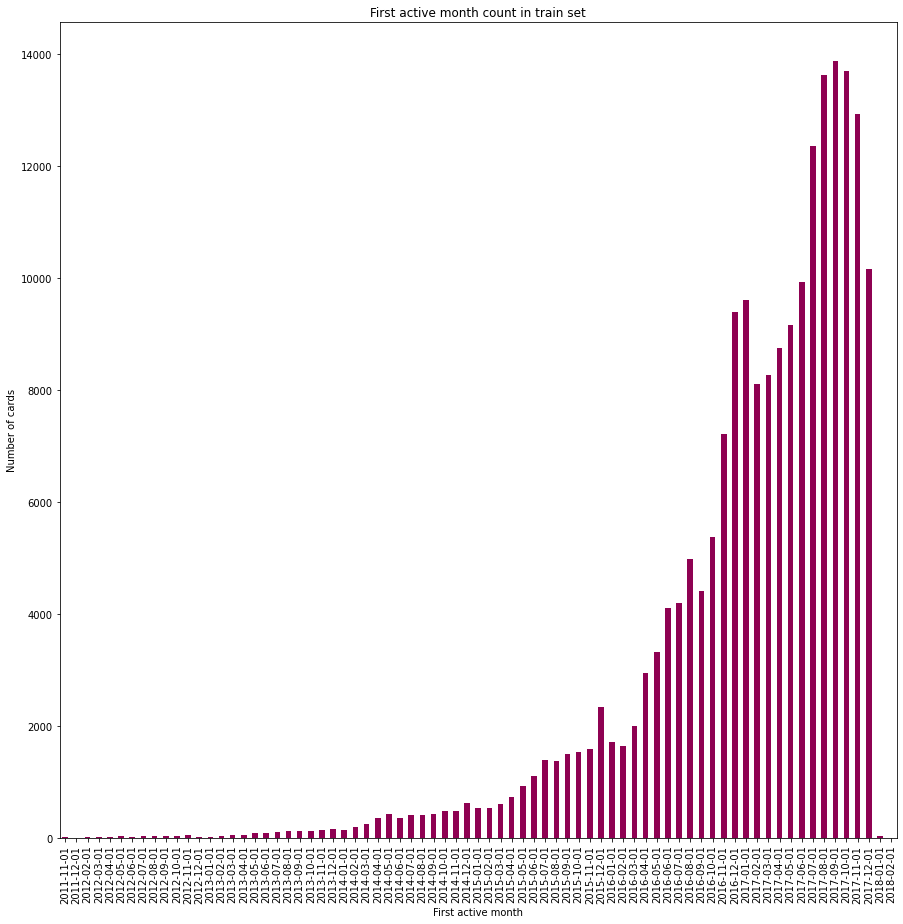

In [ ]:
cnt = train['first_active_month'].dt.date.value_counts().compute()
cvt = cnt.sort_index()

cvt.plot(kind='bar',stacked=False,figsize=[15,15],colormap='PiYG', legend=False)

plt.xlabel('First active month')
plt.ylabel('Number of cards')
plt.title('First active month count in train set')
plt.show()

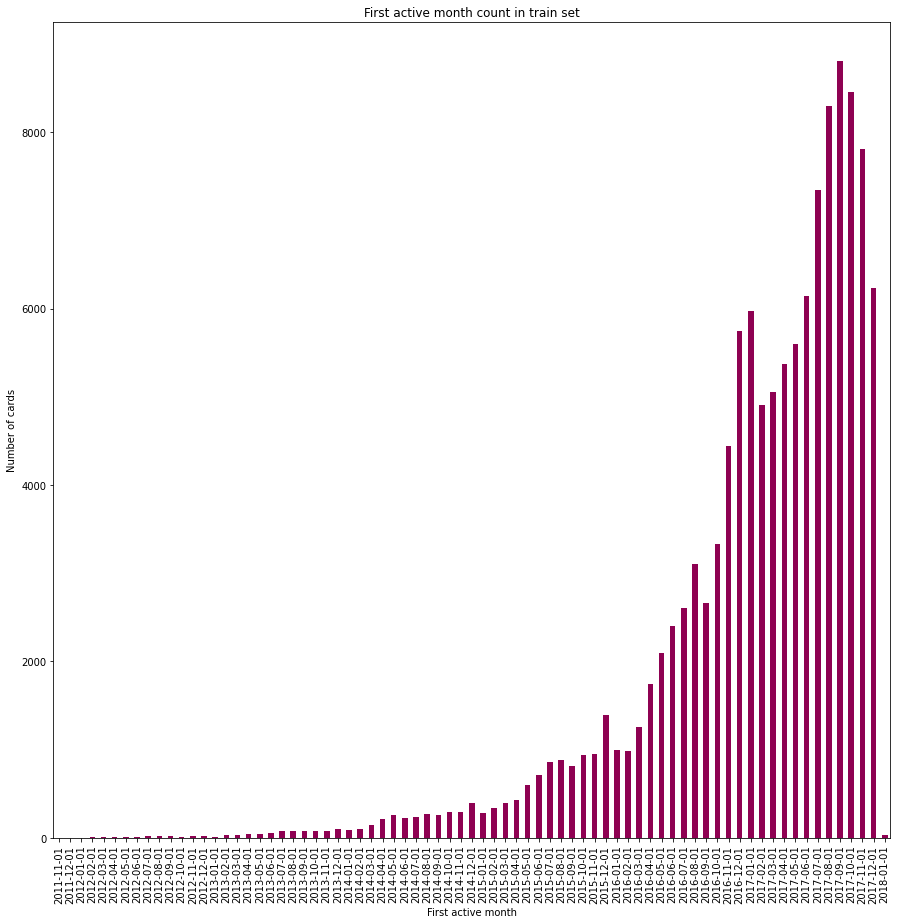

In [ ]:
cnt = test['first_active_month'].dt.date.value_counts().compute()
cvt = cnt.sort_index()

cvt.plot(kind='bar',stacked=False,figsize=[15,15],colormap='PiYG', legend=False)

plt.xlabel('First active month')
plt.ylabel('Number of cards')
plt.title('First active month count in train set')
plt.show()

As the distribution of both train and test data is same we do not need to split the data based on time. However, there is a pattern between different months of the data. Lets find out more about it further.

<h2> Finding out about reference date with respect to lag feature.</h2>

There are lag features in our data. Lets find out with which reference date have the lag feature been calculated.

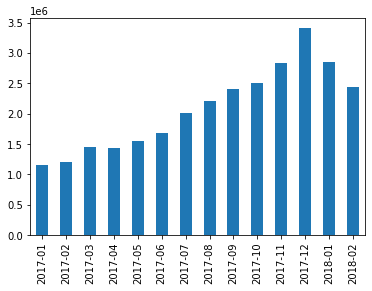

In [ ]:
hist_tran = hist_tran.assign(purchase_month = hist_tran.purchase_date.dt.to_period('M'))
counts = hist_tran.purchase_month.value_counts().compute().sort_index()
counts.plot(kind='bar')

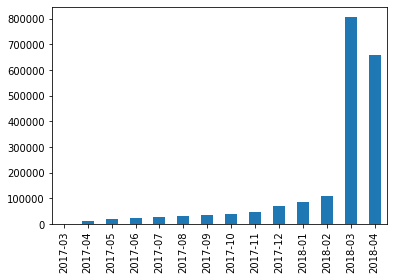

In [ ]:
new_merch_tran = new_merch_tran.assign(purchase_month = new_merch_tran.purchase_date.dt.to_period('M'))
counts = new_merch_tran.purchase_month.value_counts().compute().sort_index()
counts.plot(kind='bar')


1.   The number of historic transactions peaks in December 2017 and then begins to fall for two months.
2.   The number of new transactions peaks in March 2018, the month in which historical transactions are no longer gathered. It may mean that the month lag is calculated using a reference date between December 1st 2017 and January 1st 2018?

Lets look at the month lag feature more closely.

In [ ]:
print("The historical transaction has {0} as the minimum lag value, while {1} as the maximum value. The new merchant transaction has {2} minimum where as {3} as maximum value.".format(hist_tran.month_lag.min().compute(), hist_tran.month_lag.max().compute() , new_merch_tran.month_lag.min().compute(), new_merch_tran.month_lag.max().compute()))

The historical transaction has -13 as the minimum lag value, while 0 as the maximum value. The new merchant transaction has 1 minimum where as 2 as maximum value.


These figures defy the observation. The increase in sales in December 2017 appears to be related to seasonal demand. The reference date appears to be the 1st of February, 2018. The month lag for new transactions was not computed prior to March 1st, 2018, hence the month lag for new transactions is positive 1 and 2. The increase in sales indicated in new merchant transactions in March of 2018 appears to be related to new merchant promotions that began on the reference date.

<h2> Let us see how many customers were a part of data collected under new merchant transactions.</h2>

In [ ]:
new_merch_tran.groupby(['purchase_month', 'month_lag']).card_id.nunique().to_frame().compute().T

purchase_month 2017-03 2017-04      2017-05  ... 2018-02 2018-03        2018-04
month_lag            1       1    2       1  ...       2       1      2       2
card_id            213    2030  204    2639  ...   11707  173574  19289  167857

[1 rows x 26 columns]

In [ ]:
pd_new_merch_tran = new_merch_tran.compute()
cnts = pd_new_merch_tran.groupby([ 'month_lag', 'purchase_month']).agg({'card_id': pd.Series.nunique, 'purchase_date' : 'count'})
cnts.columns=['number of cards', 'transaction count']
cnts

number of cards  transaction count
month_lag purchase_month                                    
1         2017-03                     213               1298
          2017-04                    2030              10342
          2017-05                    2639              11750
          2017-06                    2851              12089
          2017-07                    3419              16093
          2017-08                    3692              15959
          2017-09                    4406              18089
          2017-10                    5154              21455
          2017-11                    5855              24105
          2017-12                    8688              41424
          2018-01                   12639              52501
          2018-02                   18696              67974
          2018-03                  173574             734538
2         2017-04                     204               1068
          2017-05                    1996               9281
          2017-06                    2538              11582
          2017-07                    2855              13179
          2017-08                    3211              14022
          2017-09                    3583              15238
          2017-10                    4198              16655
          2017-11                    5142              21068
          2017-12                    6076              28786
          2018-01                    7851              31533
          2018-02                   11707              42981
          2018-03                   19289              72364
          2018-04                  167857             657657

The file for new merchant transactions comprises transactions for cards that were chosen for promotions that suggested new merchants to current consumers. Since March 1st, 2017, ELO has been running promotions for new merchants at a modest pace, gradually building awareness. In March of 2017, there were 213 cards with month lag == 1. There were 18696 cards on January 1st, 2018, and by February, the promotion had reached 173574 card ids.

The offer was made available to a larger audience on March 1st, 2018. Sales to new merchants increased, while sales to existing merchants decreased, however we don't have data from previous transactoins to back this up. I assume that this rise caused ELO to conclude that the loyalty score they developed does not accurately reflect genuine consumer loyalty behaviour. There was a need for a new method of calculating loyalty scores. ELO opted to participate in this competition.

The historic transaction file contains sales from the beginning of the promotion but it excludes data from the time period covered by new transactions. This accounts for the two-month delay between historic transactions and new transactions.

The two-month lag between datasets appears to be due to the two-month data gathering period before promotion.

<h2> What to replace NULL lag values with? </h2>

Since our problem statement is not time series problem, we can just omit the rows which contains lag values, or replace them with mean or median value. We will do it afterwards, first lets perform univariate analysis on given files


# Univariate Analysis

<h2> 1. Train.csv</h2>

In [6]:
train = train.compute()

In [7]:
train.dtypes

first_active_month    datetime64[ns]
card_id                       object
feature_1                      int64
feature_2                      int64
feature_3                      int64
target                       float64
dtype: object

Lets first convert the feature types in their original type.



1.   feature_1, feeature_2, feature_3 are annonymized categorical card details, so we will convert then to **category** data type.

In [8]:
#Feature_1, Feature_2, Feature_3
train[['feature_1', 'feature_2', 'feature_3']] = train[['feature_1', 'feature_2', 'feature_3']].apply(lambda x: x. astype('category'))

<h2>1.1 Target variable </h2>

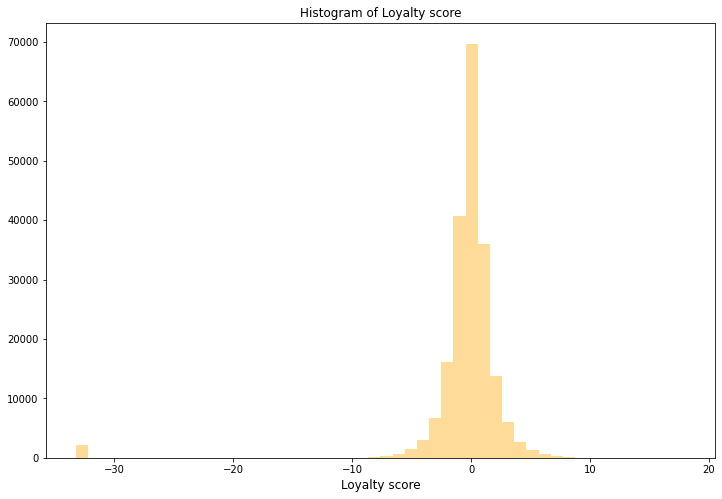

In [ ]:
#reference : https://www.kaggle.com/praxitelisk/elo-eda-ml
plt.figure(figsize=(12,8))
sns.distplot(train['target'].values, bins=50, kde=False, color="orange")
plt.title("Histogram of Loyalty score")
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

We can see that certain loyalty values are very different from others (less than -30). Let's just get a count of how many they have.

In [ ]:
print("So, there are {} total outliers present in our data.".format((train['target']<-30).sum()))

So, there are 2207 total outliers present in our data.


Lets calculate what percent of data is covered by the outliers

In [ ]:
print("There are {}% of outliers present in our data.".format(np.round((train['target']<-30).sum()*100/train.shape[0],2)))

There are 1.09% of outliers present in our data.


In [ ]:
res = train[train['target']<-30]
pd.unique(res['target'])

array([-33.21928095])

It seems all the outliers hold same value.

If we look at the distribution of target variable (excluding the outliers), it looks like the distribution of a log ratio distribution.

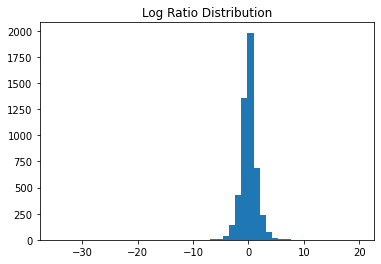

In [ ]:
# Example of log ratio distribution
a = np.random.rand(5000)
b = np.random.rand(5000)
c = np.log(a/b)
plt.hist(c, bins=np.linspace(-35, 20, 50))
plt.title('Log Ratio Distribution')
plt.show()

Checking for outlier value " -33.2192 ", lets take antilog of it and try to figure out which numbers log the distribution represents.

In [ ]:
np.exp(-33.2192)

3.741835980728729e-15

Looks like, the log of 1e-15 was the ratio value. Lets confirm on it.

In [ ]:
np.log(1e-15)

-34.538776394910684

Our assumption was not quite right, lets check further.

In [ ]:
np.log(1e-14)

-32.23619130191664

When the log is taken, a small number like 1e-14 ends up being reasonably close to the outlier values. This shows that the loyalty score is the log of a ratio of two integers, looking at the features of historical transactions and new merchant transactions, there is only feature who's ratio might have been taken. That is, "number of new purchases" divided by "number of past purchases." It's possible that the outlier numbers were obtained while the denominator was zero. Because the log of zero is negative infinity, it's possible that a small positive number was added to the denominator to avoid infinite loyalty scores. 

<h2>1.2 First Active Month </h2>

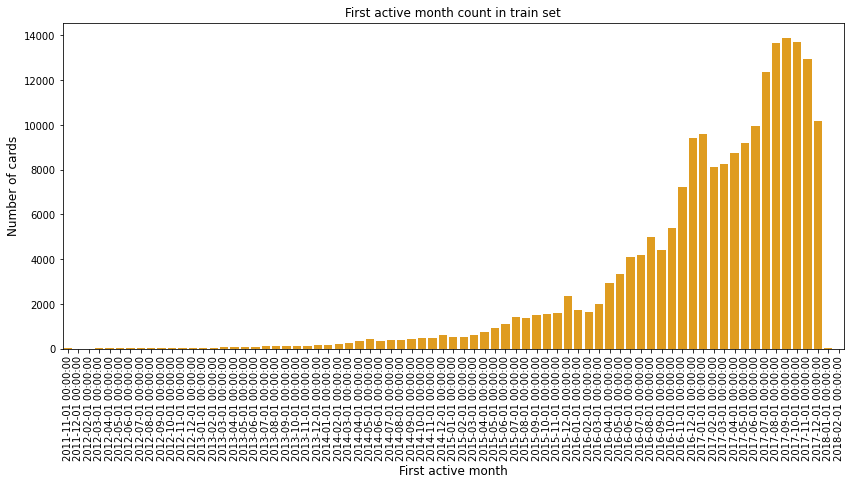

In [ ]:
#Reference : https://www.kaggle.com/praxitelisk/elo-eda-ml
count = train['first_active_month'].value_counts()
count = count.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(count.index, count.values, color='orange')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in train set")
plt.show()

There is steady rise in credit card. Lets see how much percent increase or decrease we see in card users per month, stating from December 2012.

In [ ]:
a = count.index #Getting index values
a = np.asarray(a).astype(str)

In [ ]:
dates = [x.split('T')[0] for x in a]

In [ ]:
dates.pop(0) #To make arrays of df even sized

'2011-11-01'

In [ ]:
A = count.values

In [ ]:
percent_change = [((A[i+1]-A[i])/A[i])*100 for i in range(len(A)-1)]

In [ ]:
d = {"Year and Month": dates, "Percent Change":percent_change}

df = pd.DataFrame(d)

In [ ]:
df.head()

,Year and Month,Percent Change
0,2011-12-01,-75.000000
1,2012-02-01,250.000000
2,2012-03-01,42.857143
3,2012-04-01,80.000000
4,2012-05-01,55.555556


Text(0.5, 0, 'First active month')

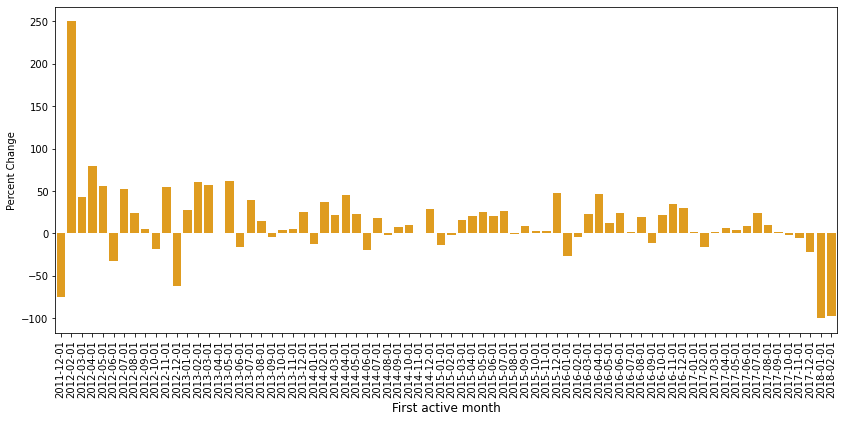

In [ ]:
plt.figure(figsize=(14,6))
chart = sns.barplot(df['Year and Month'],df['Percent Change'], color='orange')
plt.xticks(rotation="90")
plt.xlabel('First active month', fontsize=12)

Hypothesis: At first there is a decrese in number of users that use ELO card, then suddenly there was a 250% rise in card users. Ater which there in a high-low trend going on over the years. With sudden drop at the end of our time line.

We can derive a hypothesis here that, initially, people were reluctant to use the new ELO cards for online transactions. Then maybe due to its popularity or any promotional campaign, people started using the card alot. For all the months that have a percent increase in engagement of customers with the companies card, we can see what campaigns were running at that time.

As there is a sudden drop in the customer engagement with the card in the year 2018, we can say there were too many unecessary promotional campaigns happening around Brazil, and thats why ELO launched this competition. 

This is a simulated data, however this is how we can relate it to real world.

<h2>1.3 Card_id feature </h2>


In [ ]:
train.card_id.nunique()

201917

In [ ]:
train.shape[0]

201917

In [ ]:
train.card_id.min(), train.card_id.max()

('C_ID_00007093c1', 'C_ID_fffffd5772')


The card ids and number of instances of train data are same, indicating there are unique customer transaction data available to us.



<h2>1.4 Categorical Distributions</h2>

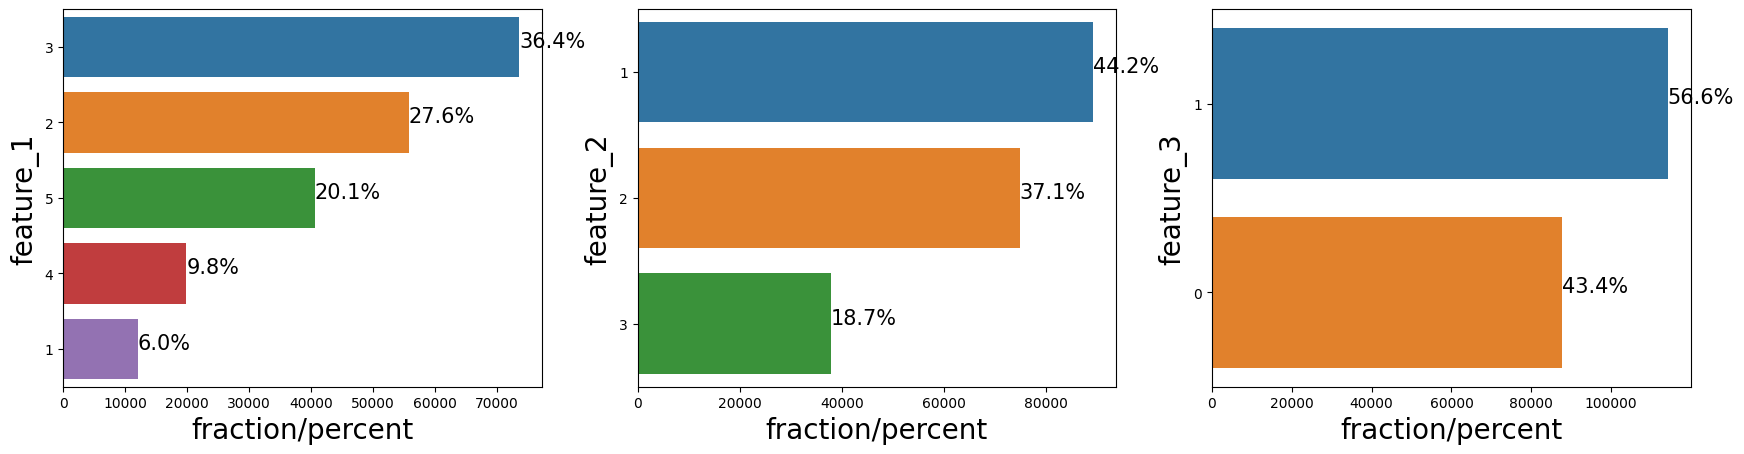

In [ ]:
categorical_distributions(train, ['feature_1', 'feature_2', 'feature_3'])

*  Feature 1: Categories 3 and 2 are the major card categories which people are possessing or like to have.
*  Feature 2: Categories 1 and 2 are the major card categories which people are possessing or like to have.

*   Feature 3: Categories 1 and 2 are equally used by customers.


In [ ]:
del train
gc.collect()

# 2. Test.csv

In [ ]:
test.dtypes

first_active_month    datetime64[ns]
card_id                       object
feature_1                      int64
feature_2                      int64
feature_3                      int64
dtype: object

In [ ]:
test = test.compute() #converting to pandas

In [ ]:
#Feature_1, Feature_2, Feature_3
test[['feature_1', 'feature_2', 'feature_3']] = test[['feature_1', 'feature_2', 'feature_3']].apply(lambda x: x. astype('category'))

<h2> 2.1 card_id </h2>

In [ ]:
test.card_id.nunique()

123623

In [ ]:
test.shape[0]

123623

In [ ]:
test.card_id.min(), test.card_id.max()

('C_ID_0001238066', 'C_ID_ffff756266')

The card ids and number of instances of test data are same, indicating there are unique customer transaction data available to us.

<h2> 2.2 First Active Month </h2>

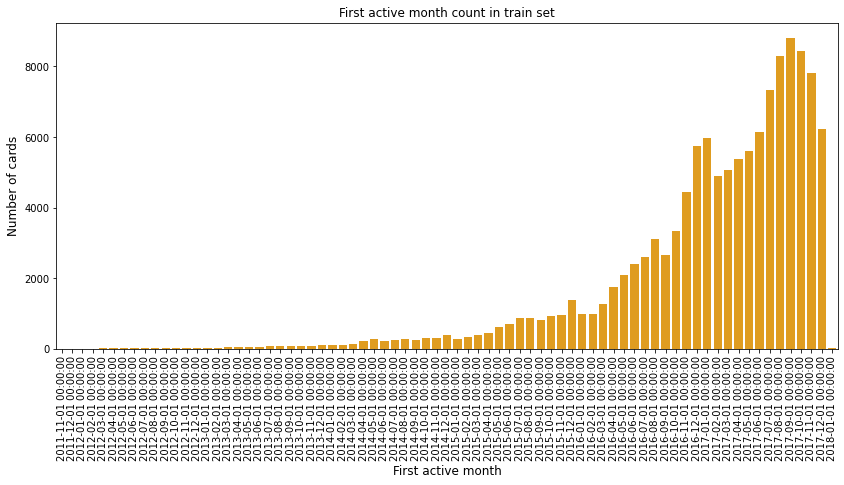

In [ ]:
count = test['first_active_month'].value_counts()
count = count.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(count.index, count.values, color='orange')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in train set")
plt.show()

The distribution of test data datetime feature is same as train data. This proves, the given problem doesn't have temporal split.

<h2> 2.3 Categorical Features </h2>

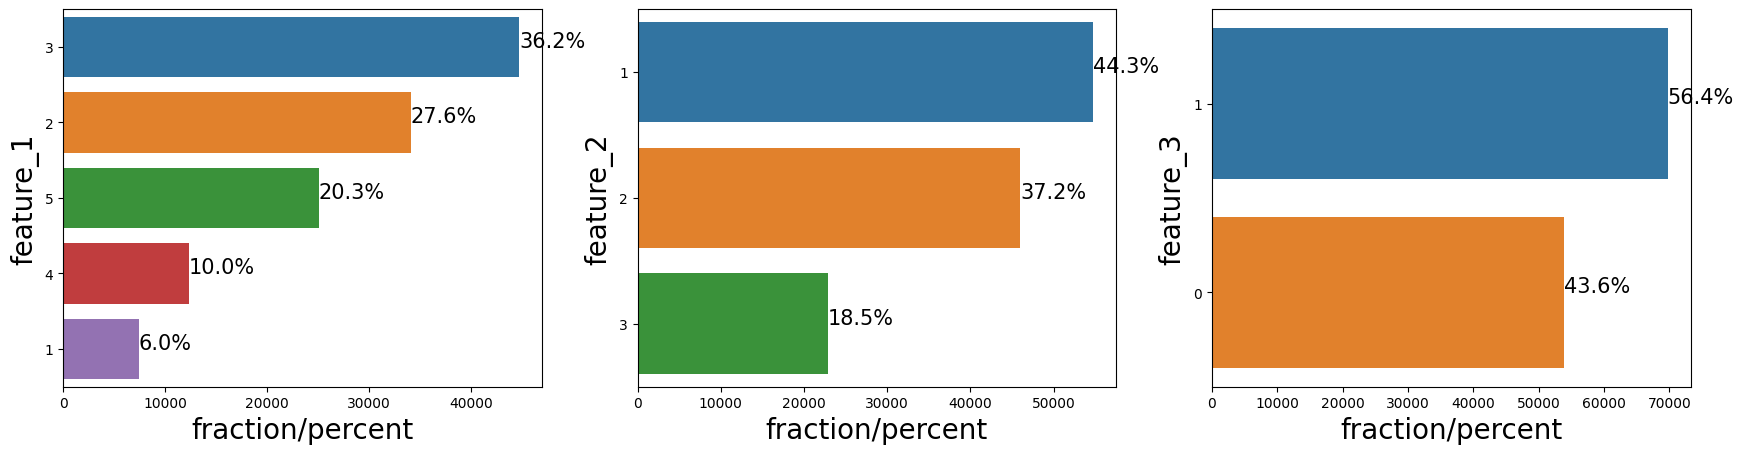

In [ ]:
categorical_distributions(test, ['feature_1', 'feature_2', 'feature_3']) #using helper function defined above

The behavior of each feature in test data is nearly same as that found in train data.

In [ ]:
del test
gc.collect()

31482

# <h2>3. Historical Transactions </h2>

In [ ]:
hist_tran = dd.read_csv("historical_transactions.csv", parse_dates=["purchase_date"])

In [ ]:
hist_tran = hist_tran.compute() #converting to pandas dataframe

In [ ]:
hist_tran.dtypes

authorized_flag                 object
card_id                         object
city_id                          int64
category_1                      object
installments                     int64
category_3                      object
merchant_category_id             int64
merchant_id                     object
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                     float64
state_id                         int64
subsector_id                     int64
dtype: object

In [ ]:
hist_tran.dtypes[hist_tran.dtypes == 'object']

authorized_flag    object
card_id            object
category_1         object
category_3         object
merchant_id        object
dtype: object



1.   authorized flag is categorized feature representing is transaction is approved or not. 
2.   category_1 and category_3 are anonymized categorical features. Lets convert it to **category**



In [16]:
#category_1, category_2, category_3
hist_tran[['authorized_flag', 'category_1', 'category_2', 'category_3']] = hist_tran[['authorized_flag', 'category_1', 'category_2', 'category_3']].apply(lambda x: x. astype('category'))

<h2> 3.1 Numerical Distribution </h2>

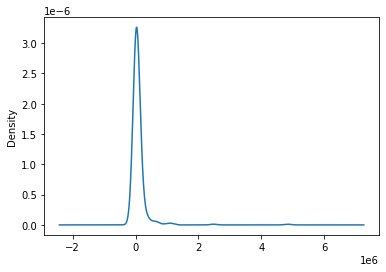

In [ ]:
hist_tran['city_id'].value_counts().sort_index().plot.kde() ##

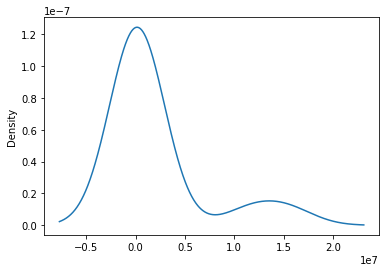

In [ ]:
hist_tran['installments'].value_counts().sort_index().plot.kde()

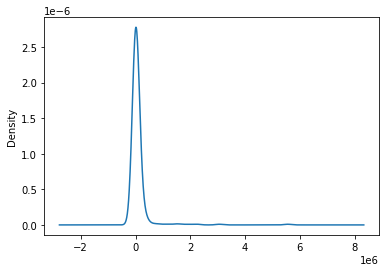

In [ ]:
hist_tran['merchant_category_id'].value_counts().sort_index().plot.kde()

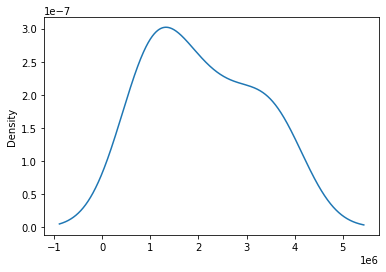

In [ ]:
hist_tran['month_lag'].value_counts().sort_index().plot.kde()

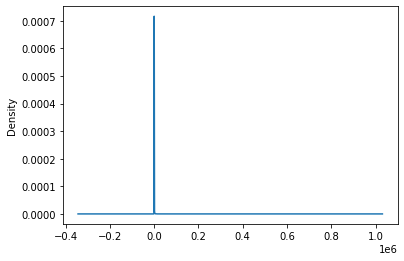

In [ ]:
hist_tran['purchase_amount'].value_counts().sort_index().plot.kde()

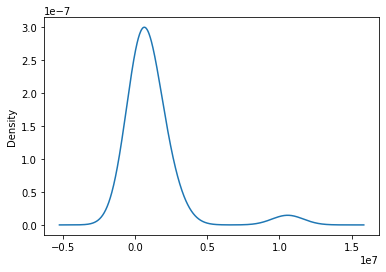

In [ ]:
hist_tran['state_id'].value_counts().sort_index().plot.kde() ##

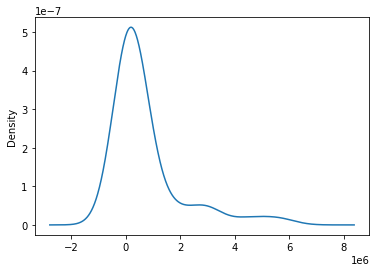

In [ ]:
hist_tran['subsector_id'].value_counts().sort_index().plot.kde() ##





*   For features ** state_id**, and **subsector_id**, **installments** there are more than one peaks present in the plot, idicating, multiple values are repeated in each of these features. One interpretation of this can also be that, the large quantity of transactions is taking place, in different states and with different merchants in Brazil.



*   features **purchase_amount**, **city_id**, **merchant_category_id** are centered around zero.



*   **month_lag -** There is a decrease in month lag from negetive values to zero.
*   **installments** and **purchase amounts** have same trand in plot, centered around zero.




<h2> 3.2 Categorical Distribution </h2>

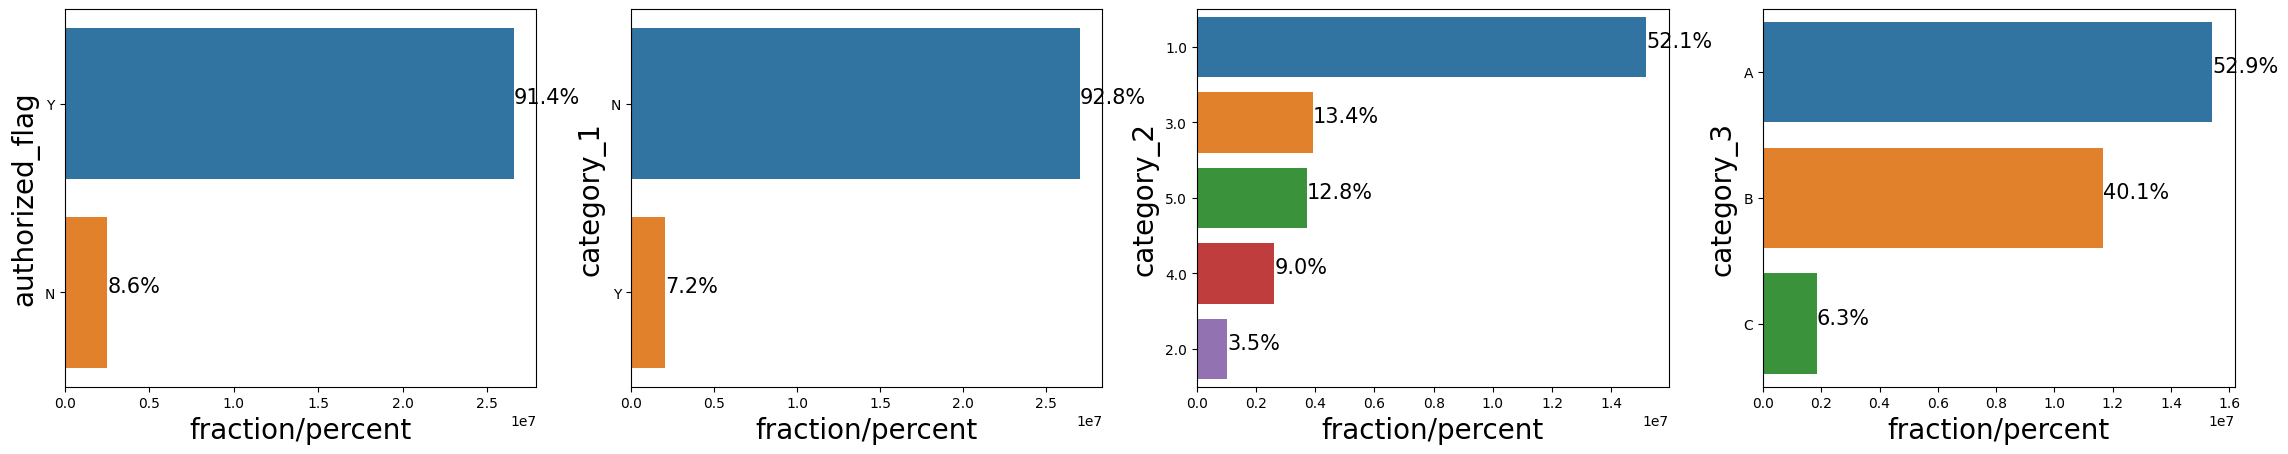

In [ ]:
categorical_distributions(hist_tran, ['authorized_flag', 'category_1', 'category_2','category_3'])



*   **authorized_flag -** The share of approved transactions is more than that of disapproved. (91.4% - approved, 8.6% - disapproved)
*   **Category_1** has two classes Y and N, where N is 92.8% and Y is 7.2%

*    **Category_2** has five classses inside it ranging from 1 to 5 with 1 being highest (53.9%) and class 2 being lowest (3.3%).





*   **Category_3** has three classes A, B, and C, where A is 52.9%, B is 40.1% and C has 6.3%.




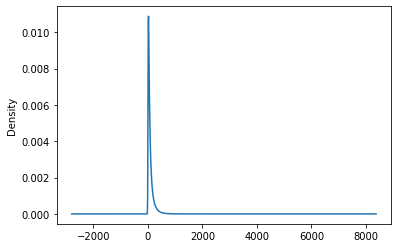

In [ ]:
hist_tran['card_id'].value_counts().sort_index().plot.kde()

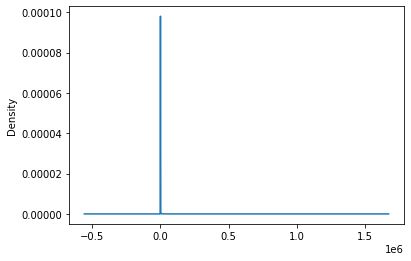

In [ ]:
hist_tran['merchant_id'].value_counts().sort_index().plot.kde()

Features **card_id** and **merchant_id** are hard to interpret.

In [ ]:
del hist_tran
gc.collect()

649

#4. New Merchant Transactions

In [ ]:
new_merch_tran = new_merch_tran.compute()

In [ ]:
new_merch_tran.dtypes

authorized_flag                 object
card_id                         object
city_id                          int64
category_1                      object
installments                     int64
category_3                      object
merchant_category_id             int64
merchant_id                     object
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                     float64
state_id                         int64
subsector_id                     int64
dtype: object

In [ ]:
new_merch_tran.dtypes[new_merch_tran.dtypes == 'object']

authorized_flag    object
card_id            object
category_1         object
category_3         object
merchant_id        object
dtype: object



*   authorized flag is categorized feature representing is transaction is approved or not.
*   category_1, category_2 and category_3 are anonymized categorical features. Lets convert it to category


In [ ]:
#category_1, category_2, category_3
new_merch_tran[['authorized_flag', 'card_id', 'merchant_id', 'category_1', 'category_2', 'category_3']] = new_merch_tran[['authorized_flag', 'card_id', 'merchant_id', 'category_1', 'category_2', 'category_3']].apply(lambda x: x. astype('category'))

In [ ]:
num_fea = ['installments', 'merchant_category_id', 'purchase_amount', 'state_id', 'subsector_id']

<h2>4.1 Numerical Distribution</h2>

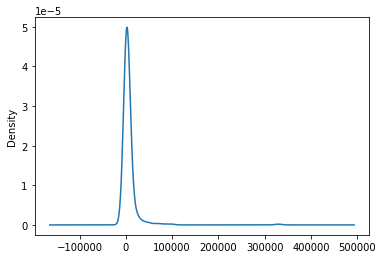

In [ ]:
new_merch_tran['city_id'].value_counts().sort_index().plot.kde()

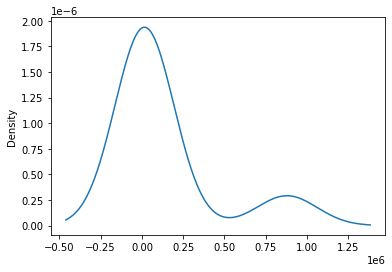

In [ ]:
new_merch_tran['installments'].value_counts().sort_index().plot.kde()

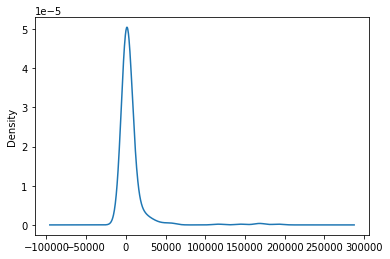

In [ ]:
new_merch_tran['merchant_category_id'].value_counts().sort_index().plot.kde()

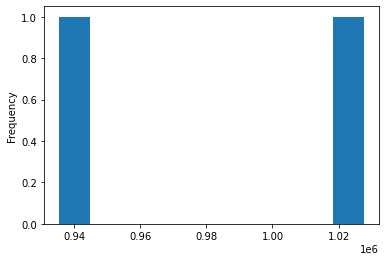

In [ ]:
new_merch_tran['month_lag'].value_counts().sort_index().plot.hist()

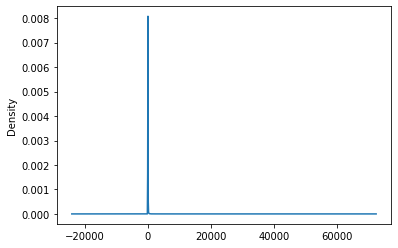

In [ ]:
new_merch_tran['purchase_amount'].value_counts().sort_index().plot.kde()

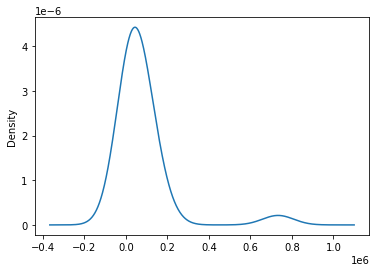

In [ ]:
new_merch_tran['state_id'].value_counts().sort_index().plot.kde()

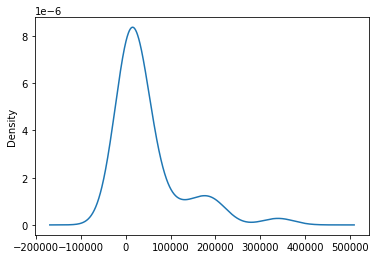

In [ ]:
new_merch_tran['subsector_id'].value_counts().sort_index().plot.kde()


*   For features ** state_id**, and **subsector_id**, **installments** there are more than one peaks present in the plot, idicating, multiple values are repeated in each of these features. One interpretation of this can also be that, the large quantity of transactions is taking place, in different states and with different merchants in Brazil.



*   features **purchase_amount**, **city_id**, **merchant_category_id** are centered around zero.



*   **month_lag -** There are two values in lag feature.
*   **installments** and **purchase amounts** have same trand in plot, centered around zero.

<h2> 4.2 Categorical Distribution </h2>

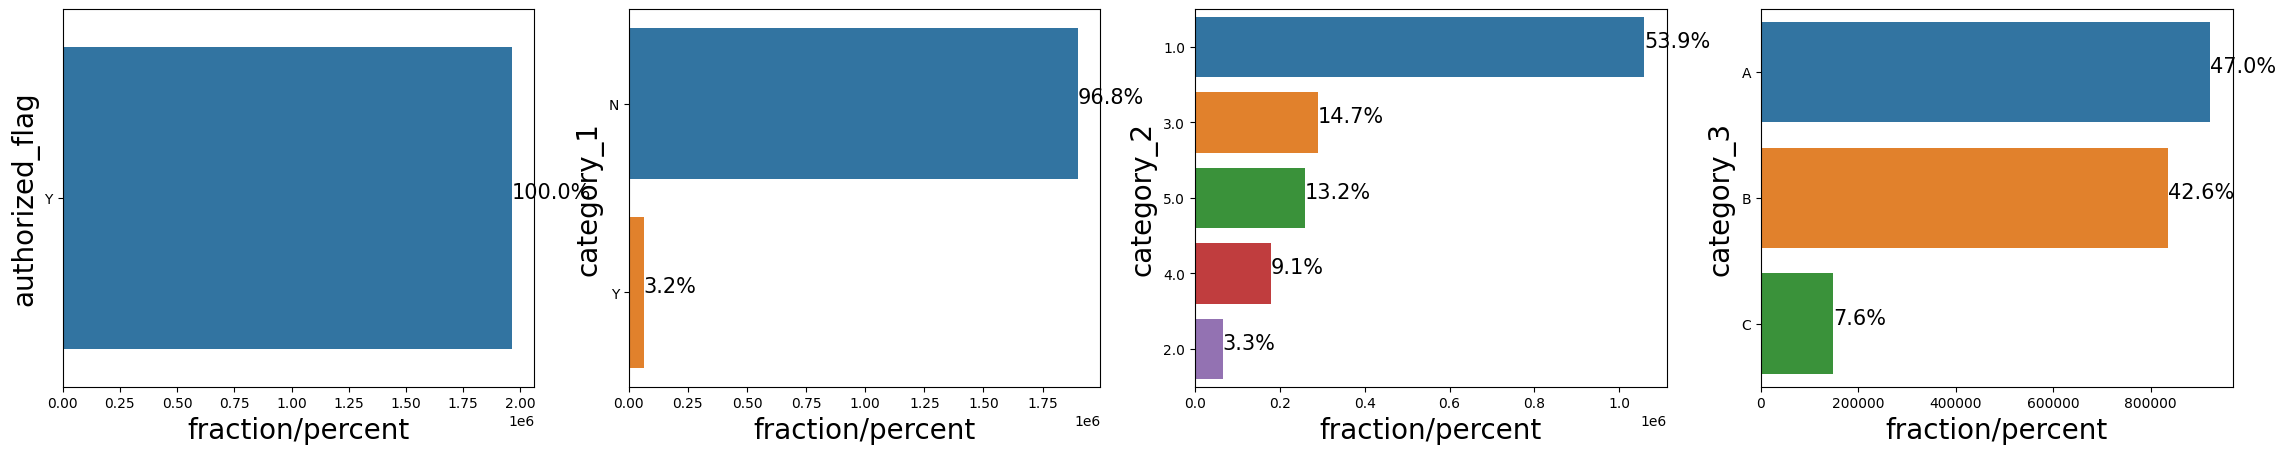

In [ ]:
categorical_distributions(new_merch_tran, ['authorized_flag', 'category_1', 'category_2', 'category_3'])

*   **authorized_flag -** All the transactions of new merchant transactions are 100% approved.
*   **Category_1** has two classes Y and N, where N is 96.8% and Y is 3.2%

*   **Category_2** has five classses inside it ranging from 1 to 5 with 1 being highest (53.9%) and class 2 being lowest (3.3%).


*   **Category_3** has three classes A, B, and C, where A is 48.8%, B is 42.6% and C has 7.6%.

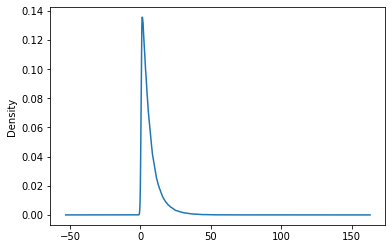

In [ ]:
new_merch_tran['card_id'].value_counts().sort_index().plot.kde()

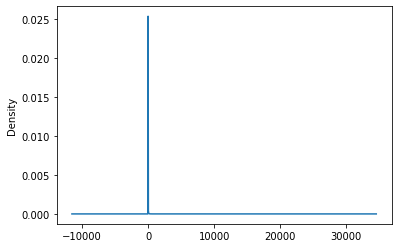

In [ ]:
new_merch_tran['merchant_id'].value_counts().sort_index().plot.kde()

Features **card_id** and **merchant_id** are hard to interpret.

In [ ]:
del new_merch_tran
gc.collect()

2574

# <h2> Merchants.csv </h2>

In [ ]:
merch = merch.compute()

In [ ]:
merch.shape

(334696, 22)

In [ ]:
merch.dtypes

merchant_id                     object
merchant_group_id                int64
merchant_category_id             int64
subsector_id                     int64
numerical_1                    float64
numerical_2                    float64
category_1                      object
most_recent_sales_range         object
most_recent_purchases_range     object
avg_sales_lag3                 float64
avg_purchases_lag3             float64
active_months_lag3               int64
avg_sales_lag6                 float64
avg_purchases_lag6             float64
active_months_lag6               int64
avg_sales_lag12                float64
avg_purchases_lag12            float64
active_months_lag12              int64
category_4                      object
city_id                          int64
state_id                         int64
category_2                     float64
dtype: object

As we have decided to drop the common features I will not be plotting any distributions of it.

In [ ]:
merch = merch.drop(['city_id', 'state_id', 'category_1', 'category_2', 'subsector_id', 'merchant_category_id', 'merchant_id'], axis=1)

In [ ]:
merch.dtypes[merch.dtypes == 'object']

most_recent_sales_range        object
most_recent_purchases_range    object
category_4                     object
dtype: object



1.   most_recent_sales_range and most_recent_purchases_range are quantiative value indicating, reange of revenue and range of transactions respectively. But they are reprented by alphabets 'A', 'B' and so on. So we will convert them to category

2.   category 1 and category 4 are anonymized categorical features. They should be category



In [ ]:
#category_1, most_recent_sales_range, mose_recent_purchases_range, category_4
merch[[ 'most_recent_sales_range', 'most_recent_purchases_range', 'category_4']] = merch[[ 'most_recent_sales_range', 'most_recent_purchases_range', 'category_4']].apply(lambda x: x. astype('category'))

In [ ]:
num_fea = ['merchant_group_id', 'numerical_1', 'numerical_2', 'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3', 'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6', 'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12' ]

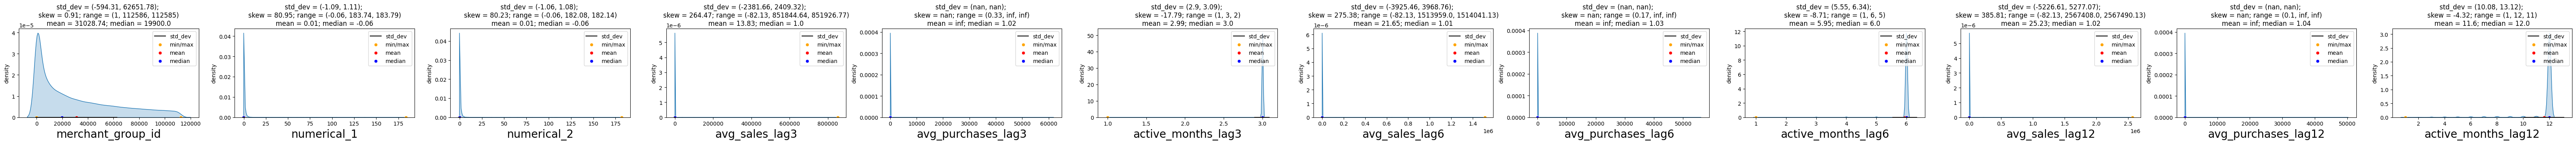

In [ ]:
numerical_distribution(merch, num_fea)



*   All the numerical features **numerical_1**, **numerical_2**, **avg_sales_lag3**, **avg_purchases_lag3**, **active_months_lag3**, **avg_sales_lag6**, **avg_purchases_lag6**, **active_months_lag6**, **avg_sales_lag12**, **avg_purchases_lag12**, **active_months_lag12** are centered around zero and hard to interpret.
*   Feaute **merchant_group_id** has a decreasing nature.





# Bivariate Analysis

1. Train.csv

Categorical features

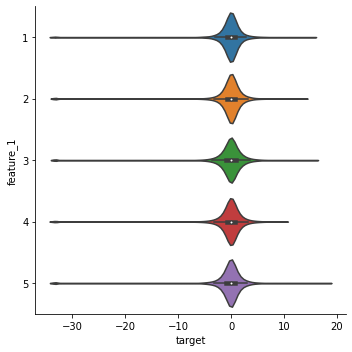

In [9]:
sns.catplot(x="target", y="feature_1", 
            kind="violin", data=train)

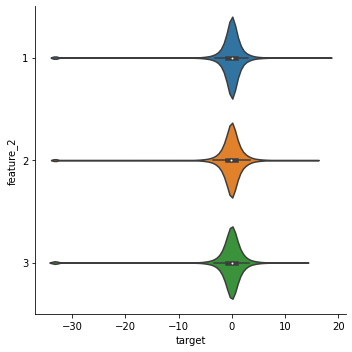

In [10]:
sns.catplot(x="target", y="feature_2", 
            kind="violin", data=train)

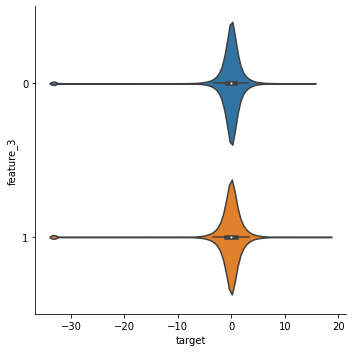

In [11]:
sns.catplot(x="target", y="feature_3", 
            kind="violin", data=train)

Not much can be said by looking at above categorical plots.

<h2> 2. Historical Transactions </h2>

In [4]:
train = train.compute()
hist_tran = hist_tran.compute()

In [12]:
hist_tran.dtypes

authorized_flag                 object
card_id                         object
city_id                          int64
category_1                      object
installments                     int64
category_3                      object
merchant_category_id             int64
merchant_id                     object
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                     float64
state_id                         int64
subsector_id                     int64
dtype: object

In [6]:
train_ids = train[['card_id','target']]

In [15]:
train_ids.shape

(201917, 2)

In [7]:
hist_tran_vs_target = pd.merge(hist_tran, train_ids, on='card_id', how='inner')

In [8]:
hist_tran_vs_target.shape

(18030009, 15)

In [21]:
hist_tran_vs_target.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,target
0,N,C_ID_5037ff576e,322,N,1,B,278,M_ID_b61c7d1be0,-3,-0.595260,2017-09-07 20:57:19,3.0,11,37,-2.352713
1,Y,C_ID_5037ff576e,138,N,1,B,307,M_ID_fe69229f24,-4,1.189469,2017-08-14 15:46:08,1.0,15,19,-2.352713
2,Y,C_ID_5037ff576e,138,N,1,B,705,M_ID_efc106141c,-9,-0.640069,2017-03-05 14:57:51,1.0,15,33,-2.352713
3,Y,C_ID_5037ff576e,226,N,1,B,307,M_ID_708022307c,-4,-0.652256,2017-08-15 10:45:28,1.0,16,19,-2.352713
4,Y,C_ID_5037ff576e,330,N,1,B,705,M_ID_393b4b8cec,-9,-0.674210,2017-03-26 20:00:31,3.0,17,33,-2.352713


In [9]:
hist_tran_vs_target.drop(hist_tran_vs_target.columns[hist_tran_vs_target.columns.str.contains('Unnamed: 0',case = False)],axis = 1, inplace = True)

In [23]:
hist_tran_vs_target.head(2)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,target
0,N,C_ID_5037ff576e,322,N,1,B,278,M_ID_b61c7d1be0,-3,-0.595260,2017-09-07 20:57:19,3.0,11,37,-2.352713
1,Y,C_ID_5037ff576e,138,N,1,B,307,M_ID_fe69229f24,-4,1.189469,2017-08-14 15:46:08,1.0,15,19,-2.352713


In [25]:
hist_tran_vs_target.dtypes

authorized_flag                 object
card_id                         object
city_id                          int64
category_1                      object
installments                     int64
category_3                      object
merchant_category_id             int64
merchant_id                     object
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                     float64
state_id                         int64
subsector_id                     int64
target                         float64
dtype: object

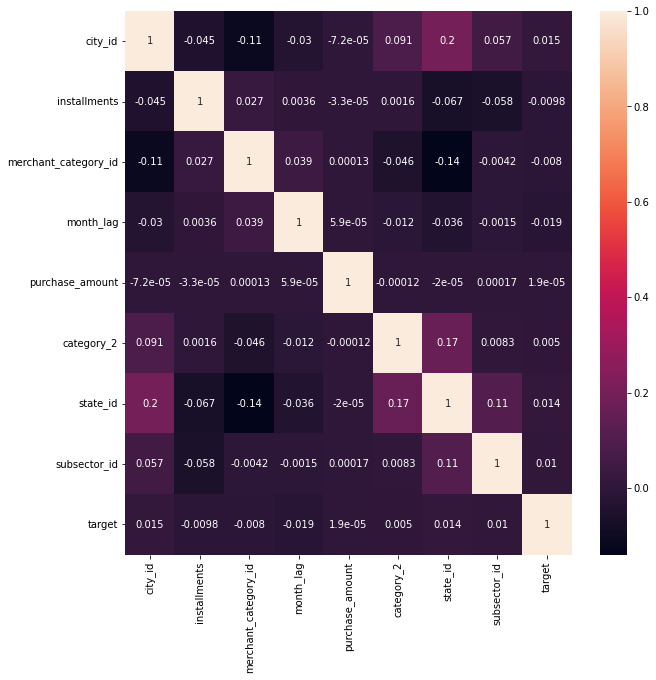

In [26]:
Var_Corr = hist_tran_vs_target.corr()

# plot the heatmap and annotation on it
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True, ax=ax)

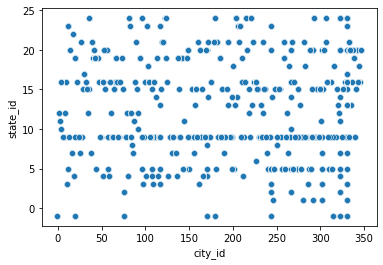

In [27]:
sns.scatterplot(x='city_id', y='state_id', data=hist_tran_vs_target)

Looking at scatter plot I can only infer that, there are transactions happening from different states.

<h2> Finding relation between categories and state and city </h2>

In [26]:
hist_tran_vs_target.dtypes

authorized_flag               category
card_id                         object
city_id                          int64
category_1                    category
installments                     int64
category_3                    category
merchant_category_id             int64
merchant_id                   category
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                    category
state_id                         int64
subsector_id                     int64
target                         float64
dtype: object

<h2>5.1.4 Undersanding Category 1 Feature </h2>

In [43]:
v1 = ['state_id','city_id']
v2 = [ 'subsector_id', 'merchant_category_id', 'installments', 'month_lag', 'purchase_amount']

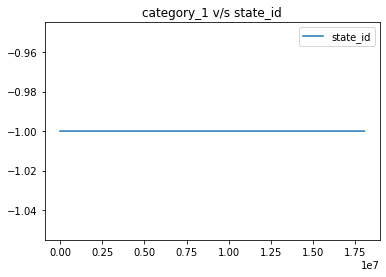

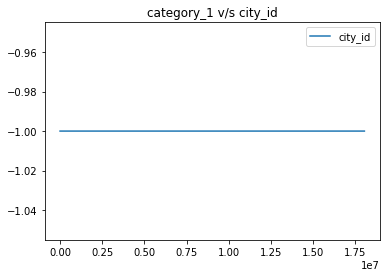

In [46]:
func1(hist_tran_vs_target, v1)

CPU times: user 3min 33s, sys: 5.03 s, total: 3min 38s
Wall time: 3min 36s


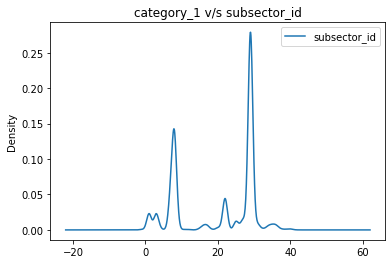

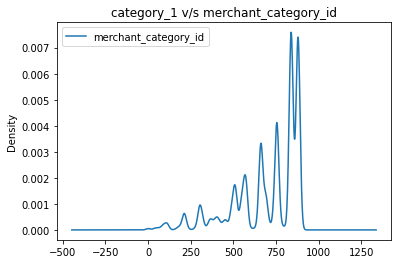

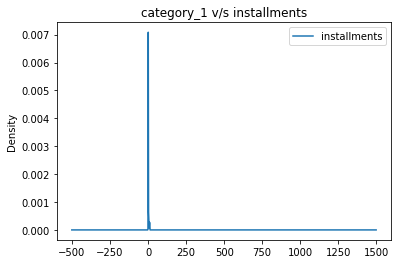

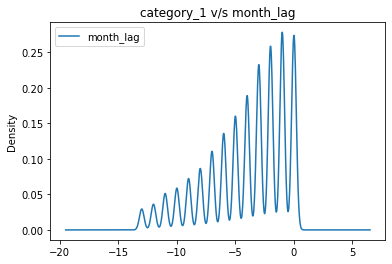

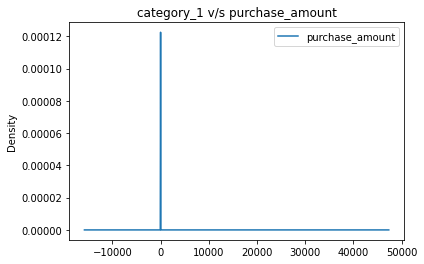

In [33]:
%%time
func2(hist_tran_vs_target,v2)

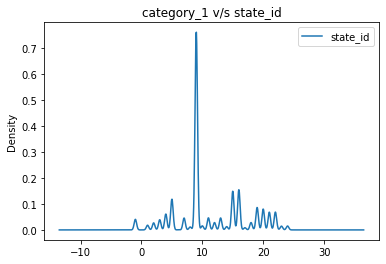

In [11]:
hist_tran_vs_target.loc[(hist_tran_vs_target["category_1"]=="N") , ["category_1",'state_id']].plot(title='category_1 v/s {0}'.format('state_id'), kind='kde')

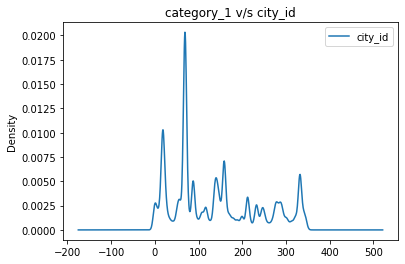

In [12]:
hist_tran_vs_target.loc[(hist_tran_vs_target["category_1"]=="N") , ['city_id']].plot(title='category_1 v/s {0}'.format('city_id'), kind='kde')

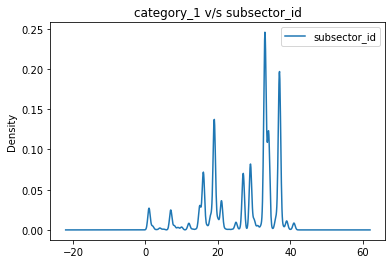

In [13]:
hist_tran_vs_target.loc[(hist_tran_vs_target["category_1"]=="N") , ['subsector_id']].plot(title='category_1 v/s {0}'.format('subsector_id'), kind='kde')

In [19]:
hist_tran.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [22]:
#category_1, category_2, category_3
hist_tran_vs_target[['authorized_flag', 'category_1', 'category_2', 'category_3', 'merchant_id']] = hist_tran_vs_target[['authorized_flag', 'category_1', 'category_2', 'category_3', 'merchant_id']].apply(lambda x: x. astype('category'))

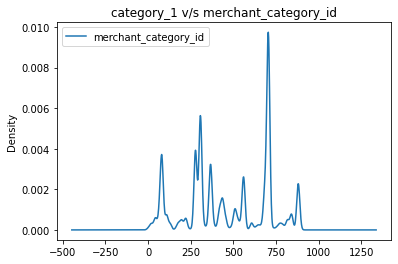

In [27]:
hist_tran_vs_target.loc[(hist_tran_vs_target["category_1"]=="N") , ['merchant_category_id']].plot(title='category_1 v/s {0}'.format('merchant_category_id'), kind='kde')

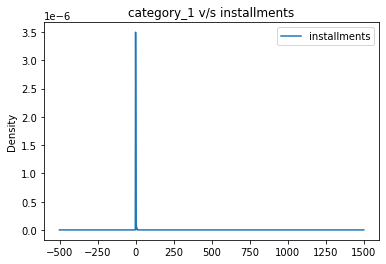

In [28]:
hist_tran_vs_target.loc[(hist_tran_vs_target["category_1"]=="N") , ['installments']].plot(title='category_1 v/s {0}'.format('installments'), kind='kde')

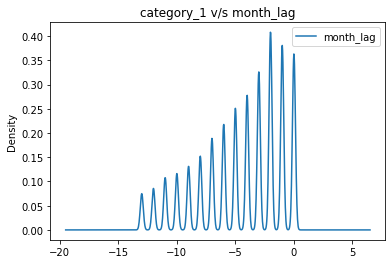

In [29]:
hist_tran_vs_target.loc[(hist_tran_vs_target["category_1"]=="N") , ['month_lag']].plot(title='category_1 v/s {0}'.format('month_lag'), kind='kde')

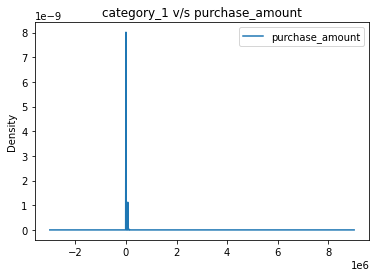

In [30]:
hist_tran_vs_target.loc[(hist_tran_vs_target["category_1"]=="N") , ['purchase_amount']].plot(title='category_1 v/s {0}'.format('purchase_amount'), kind='kde')

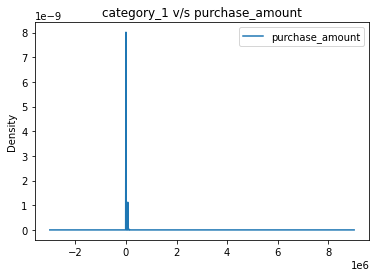

In [31]:
hist_tran_vs_target.loc[(hist_tran_vs_target["category_1"]=="N") , ['purchase_amount']].plot(title='category_1 v/s {0}'.format('purchase_amount'), kind='kde')

By looking at the plot, we see that, category 1 influences features state_id, city_id, subsector_id, merchant_id, merchant_category_id and month_lag.

We plot graphs for both the "Y" and "N" state of category 1, and after looking closely, we can say that, category 1 influences city_id feature. All the other are geographic features relating to either state or merchant location.

Since, category_1 has only two values, "Y" and "N", it may mean, that a certain transaction is from within the state or outside the state. a.k.a national or international transaction.

<h2>Understanding category_2 feature</h2>

I was unable to plot a graph. So, I'll try to figure out the relation by observing value count etc. Since category 1 give geographical transaction info. Lets assume, category 2 is related to geography too.

In [32]:
sorted(pd.unique(hist_tran_vs_target.state_id))

[-1,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

There are 26 states in Brazil in actual, but our data frame has 24 and a -1( maybe unkown value)

In [33]:
hist_tran_vs_target['category_2'].value_counts()

1.0    9417553
3.0    2426416
5.0    2295169
4.0    1617762
2.0     635717
Name: category_2, dtype: int64

In [34]:
a = hist_tran_vs_target.loc[hist_tran_vs_target['category_2']==1,'state_id']
pd.unique(a)

array([15, 16,  9, 12])

In [35]:
a = hist_tran_vs_target.loc[hist_tran_vs_target['category_2']==2,'state_id']
pd.unique(a)

array([24, 23, 18, 10,  6])

In [36]:
a = hist_tran_vs_target.loc[hist_tran_vs_target['category_2']==3,'state_id']
pd.unique(a)

array([11, 17, 19,  3,  8,  7,  1,  2])

In [37]:
a = hist_tran_vs_target.loc[hist_tran_vs_target['category_2']==4,'state_id']
pd.unique(a)

array([ 4, 22, 13, 14])

In [38]:
a = hist_tran_vs_target.loc[hist_tran_vs_target['category_2']==5,'state_id']
pd.unique(a)

array([ 5, 20, 21])

Each value of category_2 covers some states, therefore it is safe to say that, category_2 represents 5 regions of Brazil. Thus category_2 gives info about regions in Brazil

<h2> Understanding Category 3 Feature </h2>

In [47]:
v_all = ['state_id', 'city_id', 'subsector_id', 'merchant_category_id',  'month_lag', 'purchase_amount']

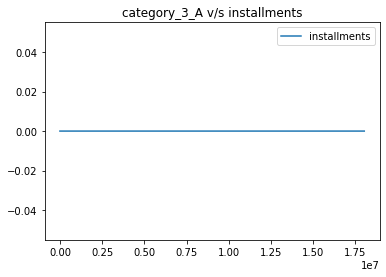

In [48]:
v = ['installments']

func8(hist_tran_vs_target,v) #A

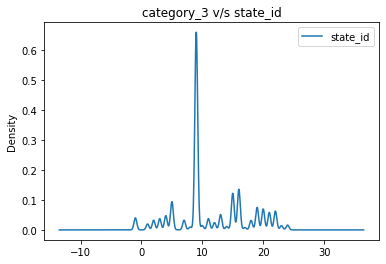

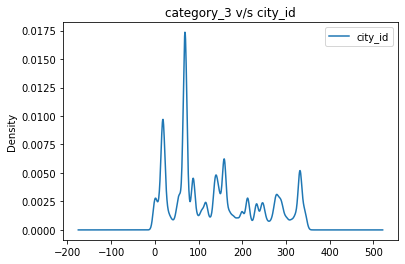

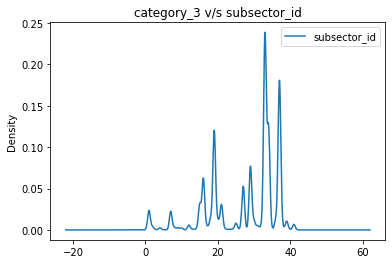

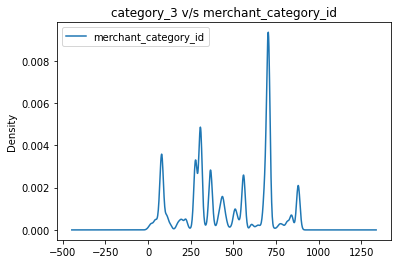

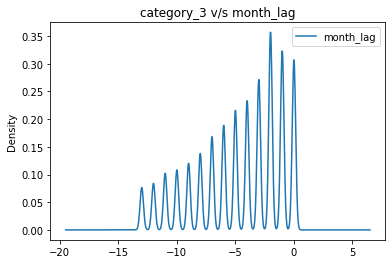

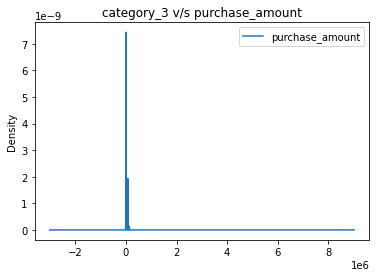

In [49]:
func5(hist_tran_vs_target,v_all)

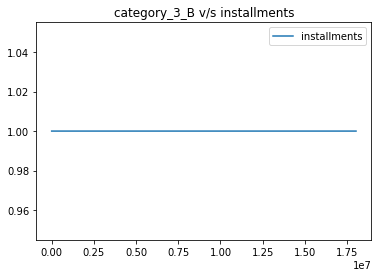

In [50]:
v = ['installments']

func9(hist_tran_vs_target,v) #B done till here

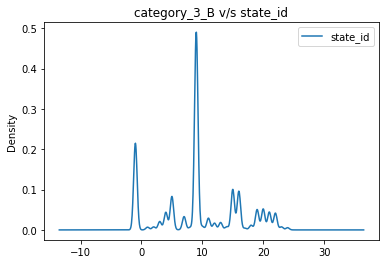

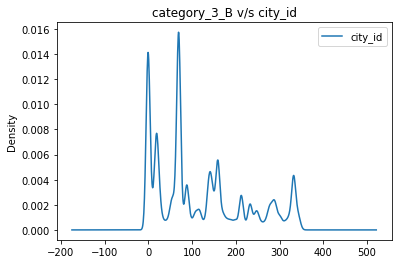

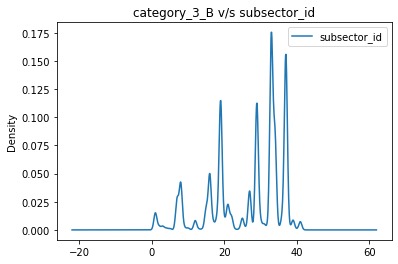

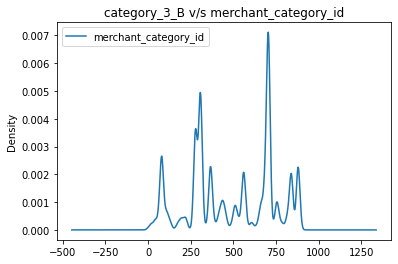

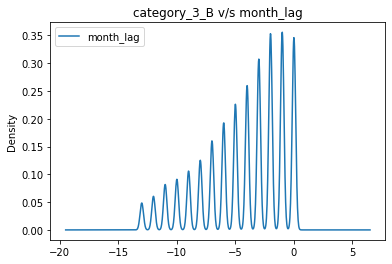

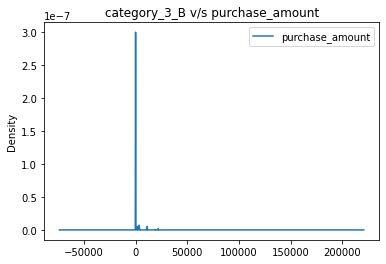

In [51]:
func6(hist_tran_vs_target,v_all)

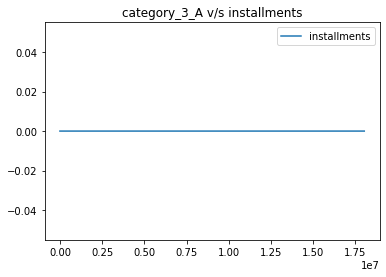

In [52]:
v = ['installments']

func8(hist_tran_vs_target,v) #C

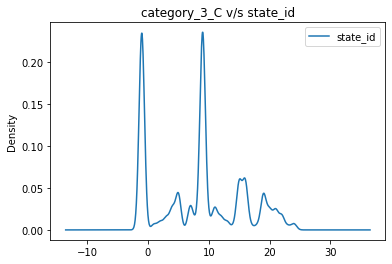

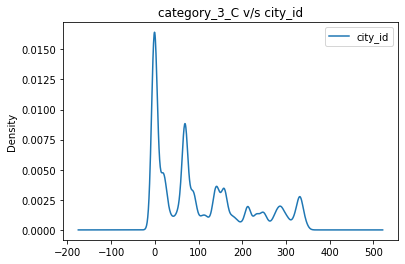

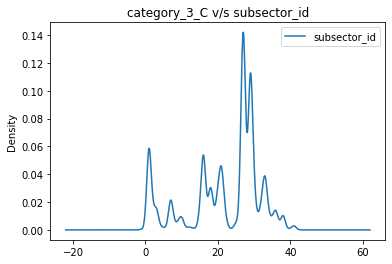

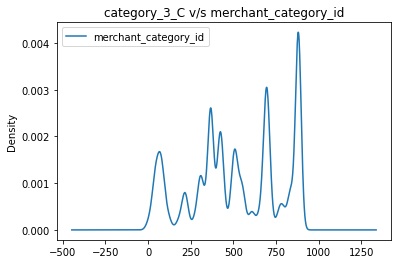

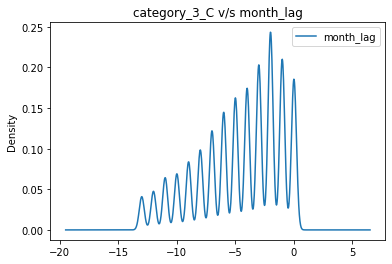

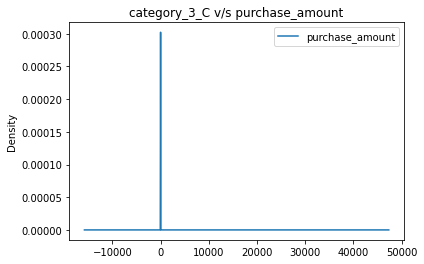

In [53]:
func7(hist_tran_vs_target,v_all)

It is quite difficult to know which feature category 3 might represent. This feature influences a bunch of features like, city_id, state_id, merchant_id, merchant_category_id, subsector_id and month_lag.

In [54]:
v_all1 = ['state_id', 'city_id', 'subsector_id']

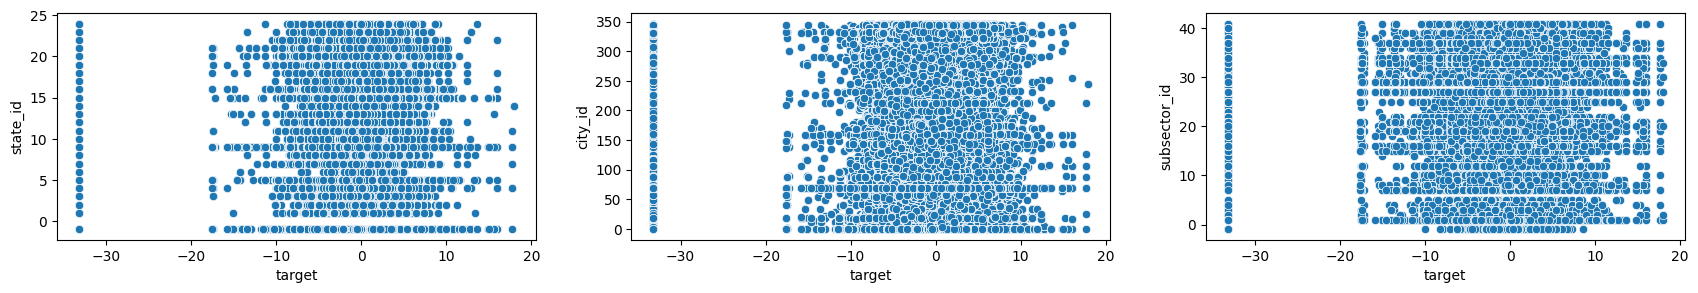

In [55]:
historical_vs_target(hist_tran_vs_target, v_all1)

In [56]:
v_all2 = [ 'merchant_category_id',  'month_lag', 'purchase_amount']

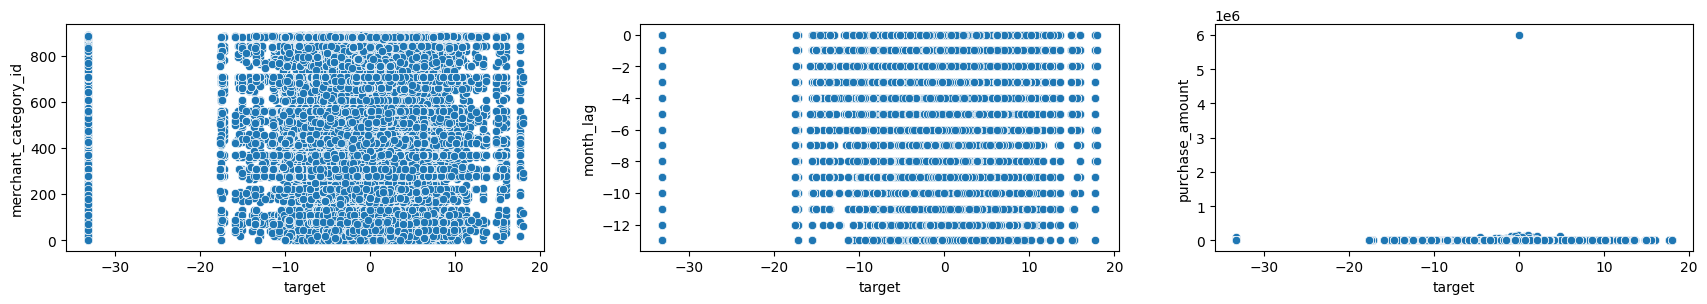

In [57]:
historical_vs_target(hist_tran_vs_target, v_all2)

Not much can be infered by looking at the feature v/s target plot as, the features are not highly correlated.

<h2> Lets see how purchase amount has any effect on target variable in a different manner </h2>

In [58]:
df_new = hist_tran.groupby("card_id")
df_new = df_new["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()

In [59]:
#Reference: https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo

gdf = hist_tran.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", "min_hist_trans", "max_hist_trans"]
train_df = pd.merge(train, gdf, on="card_id", how="left")

In [60]:
gdf

,card_id,sum_hist_trans,mean_hist_trans,std_hist_trans,min_hist_trans,max_hist_trans
0,C_ID_00007093c1,-76.845041,-0.515739,0.298141,-0.728876,1.507069
1,C_ID_0001238066,-72.447201,-0.589002,0.190235,-0.734887,0.768095
2,C_ID_0001506ef0,-34.601879,-0.524271,0.472284,-0.740491,1.493545
3,C_ID_0001793786,-36.786013,-0.170306,0.836046,-0.745405,4.554145
4,C_ID_000183fdda,-68.837938,-0.478041,0.524948,-0.737892,2.764788
...,...,...,...,...,...,...
325535,C_ID_ffff1d9928,-7.477673,-0.623139,0.225025,-0.746893,0.004418
325536,C_ID_ffff579d3a,-80.292768,-0.704323,0.042052,-0.739244,-0.491457
325537,C_ID_ffff756266,-5.506420,-0.229434,0.517191,-0.746156,1.206403
325538,C_ID_ffff828181,-120.099200,-0.632101,0.109907,-0.745405,0.109528


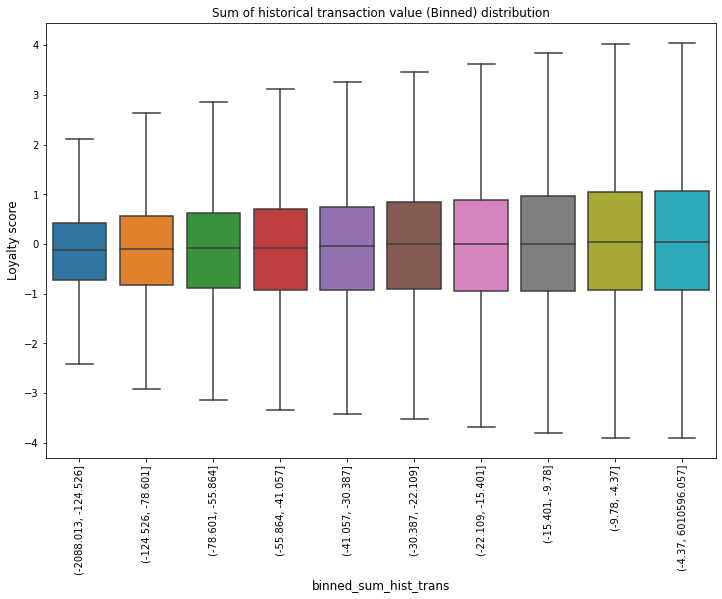

In [61]:
bins = np.percentile(train_df["sum_hist_trans"], range(0,101,10))
train_df['binned_sum_hist_trans'] = pd.cut(train_df['sum_hist_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_hist_trans", y='target', data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_sum_hist_trans', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of historical transaction value (Binned) distribution")
plt.show()

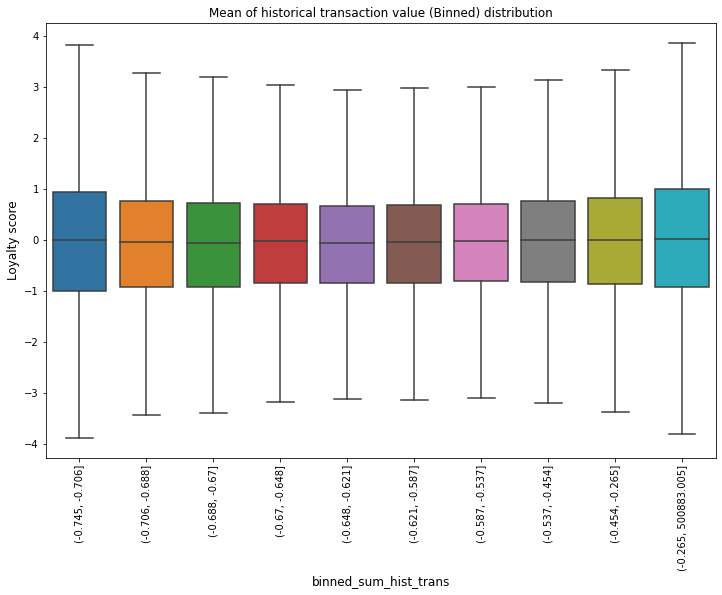

In [62]:
bins = np.percentile(train_df["mean_hist_trans"], range(0,101,10))
train_df['binned_mean_hist_trans'] = pd.cut(train_df['mean_hist_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_mean_hist_trans", y='target', data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_sum_hist_trans', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Mean of historical transaction value (Binned) distribution")
plt.show()

In [63]:
df_new.head()

,card_id,sum,mean,std,min,max
0,C_ID_00007093c1,-76.845041,-0.515739,0.298141,-0.728876,1.507069
1,C_ID_0001238066,-72.447201,-0.589002,0.190235,-0.734887,0.768095
2,C_ID_0001506ef0,-34.601879,-0.524271,0.472284,-0.740491,1.493545
3,C_ID_0001793786,-36.786013,-0.170306,0.836046,-0.745405,4.554145
4,C_ID_000183fdda,-68.837938,-0.478041,0.524948,-0.737892,2.764788


In [64]:
train_new = pd.merge(train, df_new, on="card_id", how='left')

In [65]:
train_new.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,sum,mean,std,min,max
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,-165.968739,-0.638341,0.212139,-0.739395,2.258395
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,-210.006336,-0.600018,0.384967,-0.742400,4.630299
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,-29.167391,-0.678311,0.087380,-0.730138,-0.145847
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,-49.491364,-0.642745,0.261624,-0.740897,1.445596
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,-48.687656,-0.366073,1.352094,-0.746156,7.193041


In [66]:
train_new.shape

(201917, 11)

In [67]:
train_new.isnull().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
sum                   0
mean                  0
std                   0
min                   0
max                   0
dtype: int64

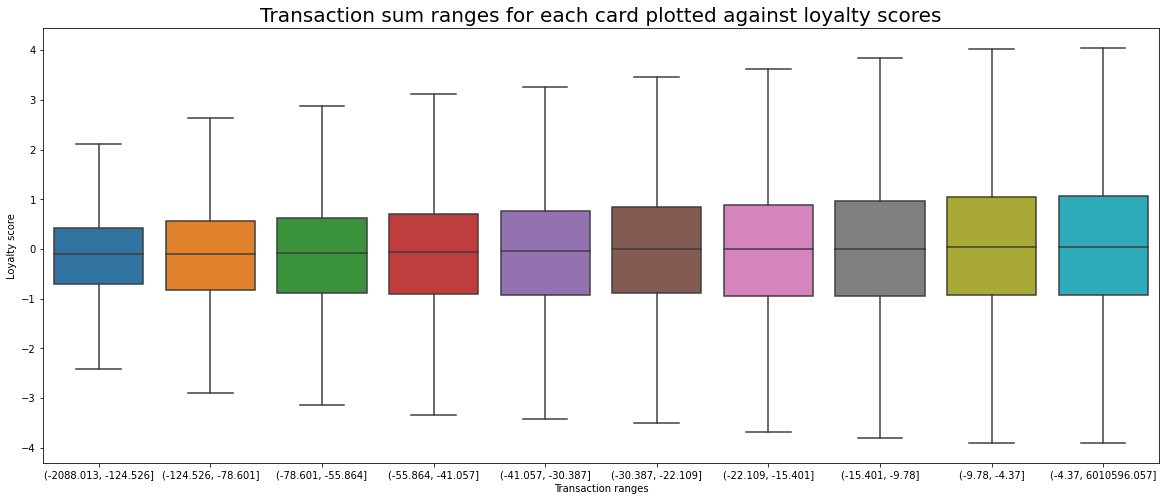

In [68]:
bins = np.percentile(train_new["sum"], range(0,101,10))
train_new['binned_sum_hist_trans'] = pd.cut(train_new['sum'], bins)

plt.figure(figsize=(20,8))
sns.boxplot(x="binned_sum_hist_trans", y=train_new['target'], data=train_new, showfliers=False)
#plt.xticks(rotation='vertical')
plt.xlabel('Transaction ranges')
plt.ylabel('Loyalty score')
plt.title("Transaction sum ranges for each card plotted against loyalty scores", fontsize = 20)
plt.show()

the loyalty score seem to increase with the "sum of historical transaction value". This is expected. Now we can do the same plot with "Mean value of historical transaction".

<h2> New Merchant Transaction </h2>

In [71]:
new_merch_tran = new_merch_tran.compute()

In [69]:
new_merch_tran.dtypes

authorized_flag                 object
card_id                         object
city_id                          int64
category_1                      object
installments                     int64
category_3                      object
merchant_category_id             int64
merchant_id                     object
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                     float64
state_id                         int64
subsector_id                     int64
dtype: object

In [72]:
new_merch_and_target = pd.merge(new_merch_tran, train_ids, on='card_id', left_index=True, right_index=True)

In [73]:
new_merch_and_target.drop(new_merch_and_target.columns[new_merch_and_target.columns.str.contains('Unnamed: 0',case = False)],axis = 1, inplace = True)

In [74]:
new_merch_and_target.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,target
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19,-0.820283
0,Y,C_ID_56566f5176,4,N,0,A,278,M_ID_ad6d79f156,2,-0.706186,2018-04-26 13:45:15,2.0,10,37,-0.820283
0,Y,C_ID_8ffc096994,69,N,1,B,462,NaN,1,-0.711295,2018-03-11 12:14:17,1.0,9,31,-0.820283
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19,0.392913
1,Y,C_ID_56566f5176,4,N,0,A,307,M_ID_c9b217ccfc,1,-0.701828,2018-03-13 19:55:11,2.0,10,19,0.392913


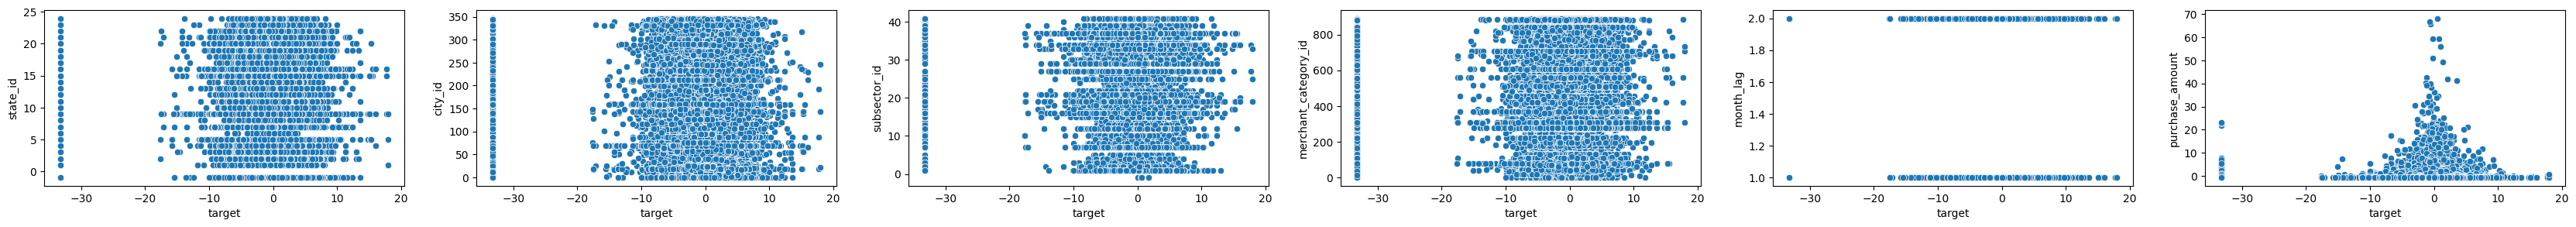

In [76]:
historical_vs_target(new_merch_and_target, v_all)

Not much can be infered by looking at the feature v/s target plot as, the features are not highly correlated.